In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
train_targets = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/A/train_targets.parquet')
X_train_observed = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/A/X_train_observed.parquet')
X_train_estimated = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/A/X_train_estimated.parquet')


In [16]:
X_train_estimated.head()

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2022-10-27 07:00:18 2022-10-28 22:00:00                       8.4   
1 2022-10-27 07:00:18 2022-10-28 22:15:00                       8.4   
2 2022-10-27 07:00:18 2022-10-28 22:30:00                       8.3   
3 2022-10-27 07:00:18 2022-10-28 22:45:00                       8.3   
4 2022-10-27 07:00:18 2022-10-28 23:00:00                       8.2   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.233           1425.099976                    0.0   
1                1.233           2085.899902                    0.0   
2                1.233           2746.600098                    0.0   
3                1.233           3407.399902                    0.0   
4                1.233           4068.199951                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1211.699951              1.0      281.399994  ...   
1              0.0       1560.500000              1.0      281.299988  ...   
2              0.0       1909.400024              1.0      281.200012  ...   
3              0.0       2258.199951              1.0      281.200012  ...   
4              0.0       2607.000000              1.0      281.100006  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     340.799011       -38.466999                             0.0   
1     345.451996       -38.955002                             0.0   
2     350.153015       -39.310001                             0.0   
3     354.886993       -39.528999                             0.0   
4     359.638000       -39.609001                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   284.700012                100.0  29429.699219                0.8   
1   284.700012                100.0  23604.099609                0.7   
2   284.700012                100.0  17799.800781                0.7   
3   284.600006                100.0  12016.500000                0.6   
4   284.600006                100.0   6254.399902                0.6   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -0.4                  0.7                     -0.0  
1                 -0.4                  0.7                     -0.0  
2                 -0.3                  0.6                     -0.0  
3                 -0.2                  0.6                     -0.0  
4                 -0.1                  0.6                     -0.0  

[5 rows x 47 columns]

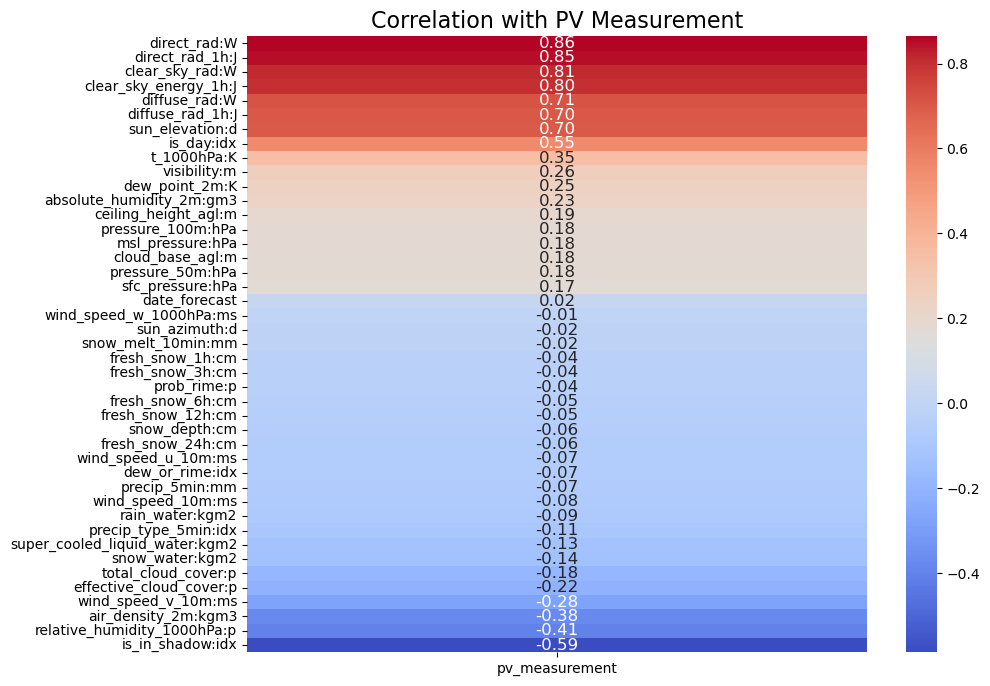

In [17]:
# Rename Columns
train_targets.rename(columns={'time': 'date_forecast'}, inplace=True)

# Align Time Intervals
X_train_observed_1hr = X_train_observed.groupby(pd.Grouper(key='date_forecast', freq='1H')).mean()

# Merge DataFrames
real_data = pd.merge(train_targets, X_train_observed_1hr.reset_index(), on='date_forecast')

# To fill NaN values with the mean
# Exclude constant features from the data before calculating correlation
filtered_real_data = real_data.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx'])

# Recalculate the correlation matrix
real_corr = filtered_real_data.corr()

# Filter to only include correlation with 'pv_measurement' and sort it
real_corr_with_target = real_corr[['pv_measurement']].sort_values(by='pv_measurement', ascending=False)


# Remove the 'pv_measurement' row to exclude the correlation of the target with itself
real_corr_with_target = real_corr_with_target.drop(index='pv_measurement')
# print(real_corr_with_target)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(real_corr_with_target, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title("Correlation with PV Measurement", fontsize=16)
plt.show()



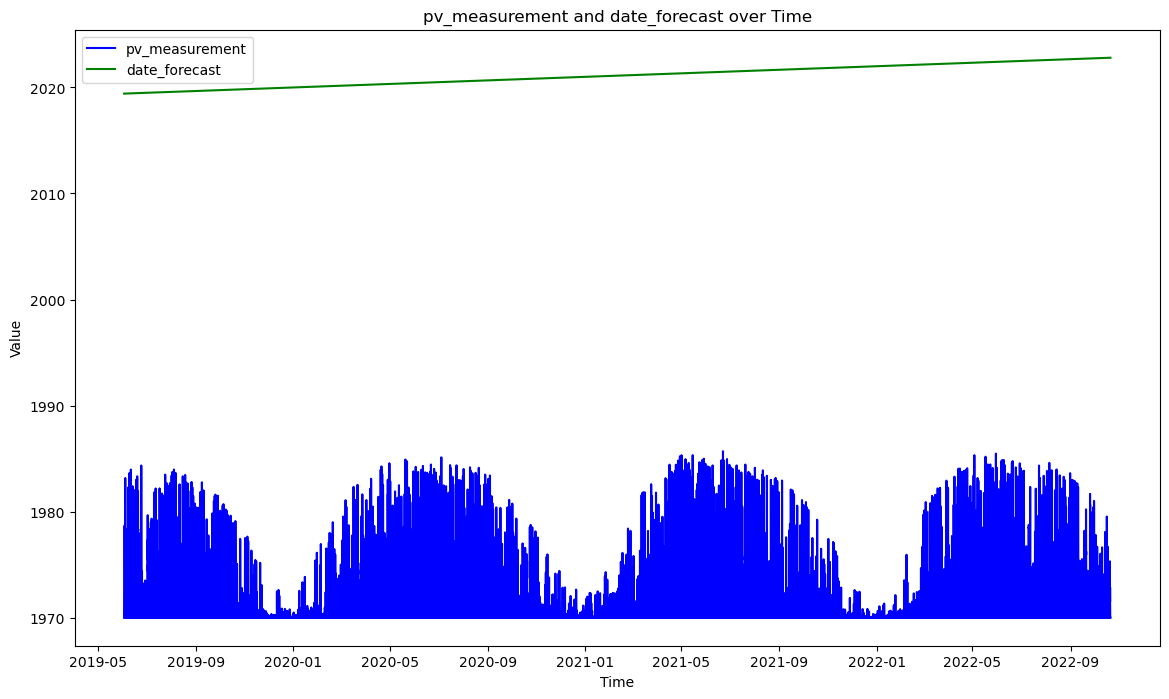

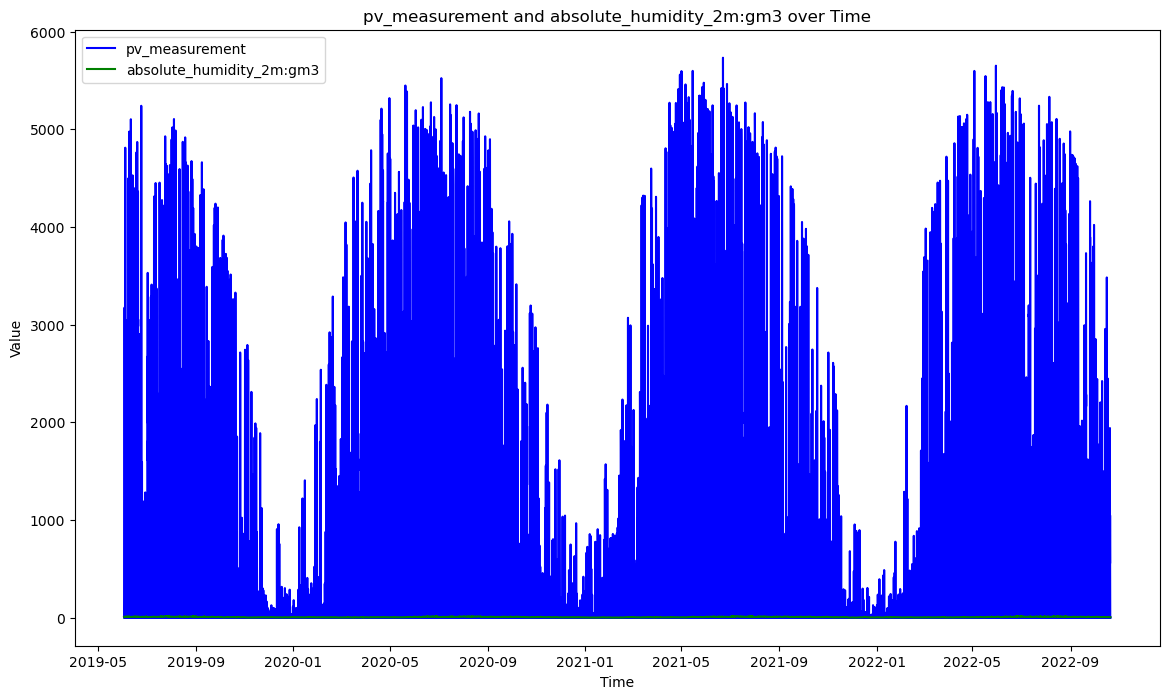

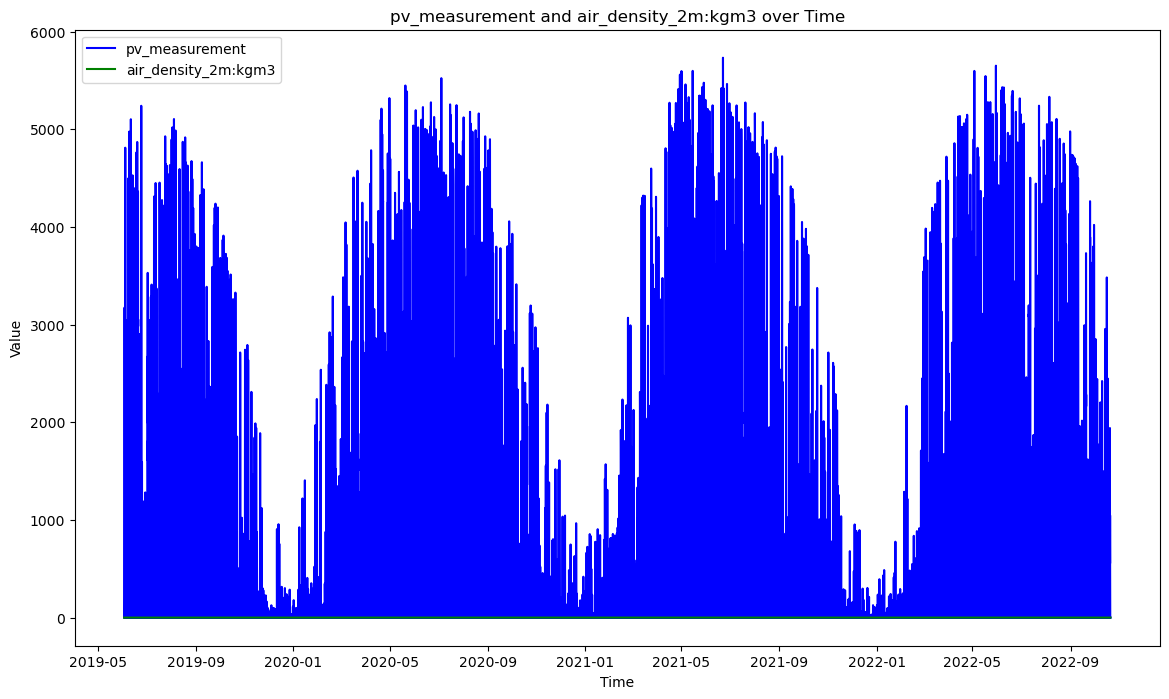

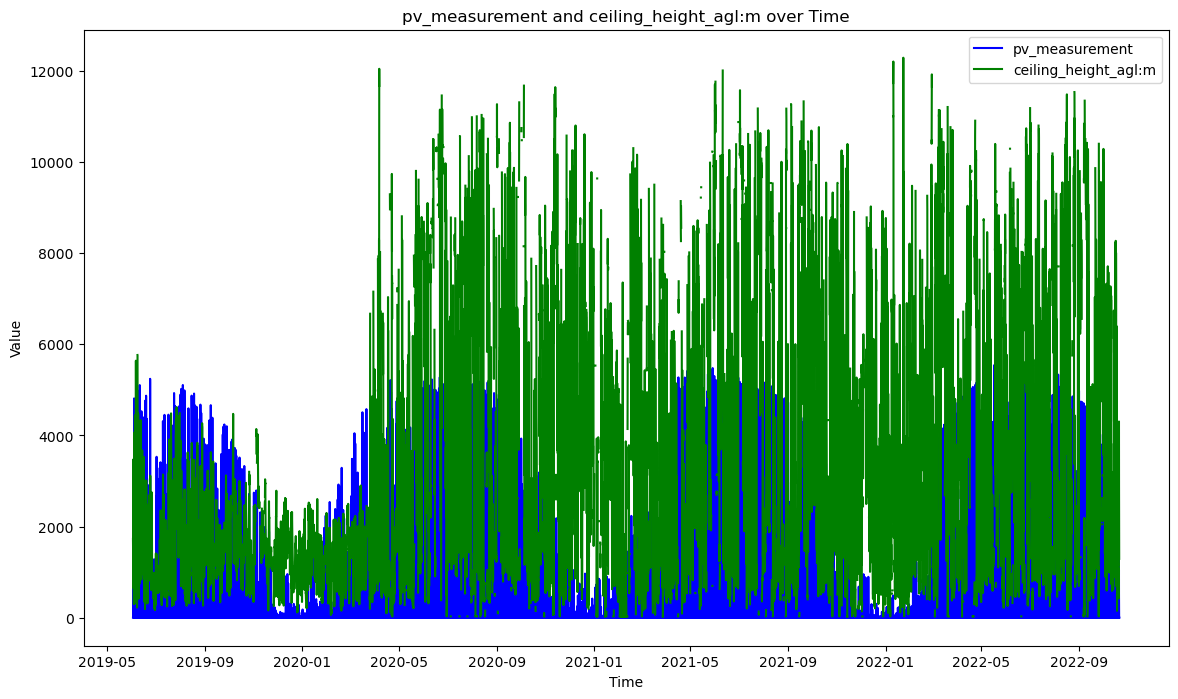

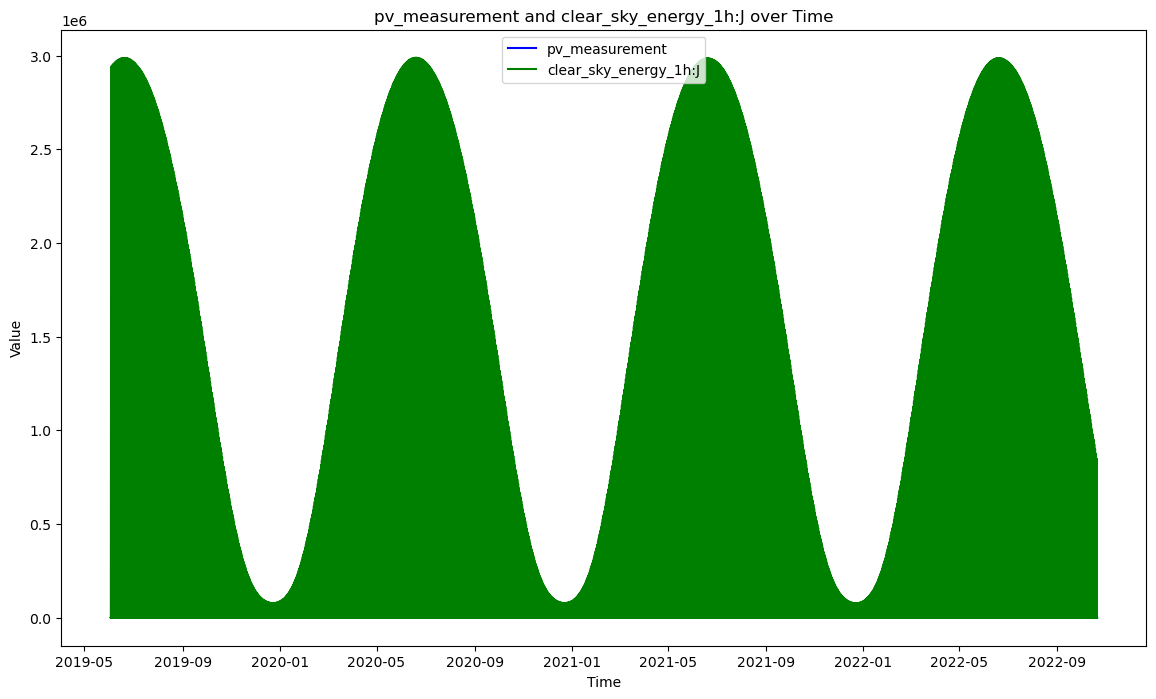

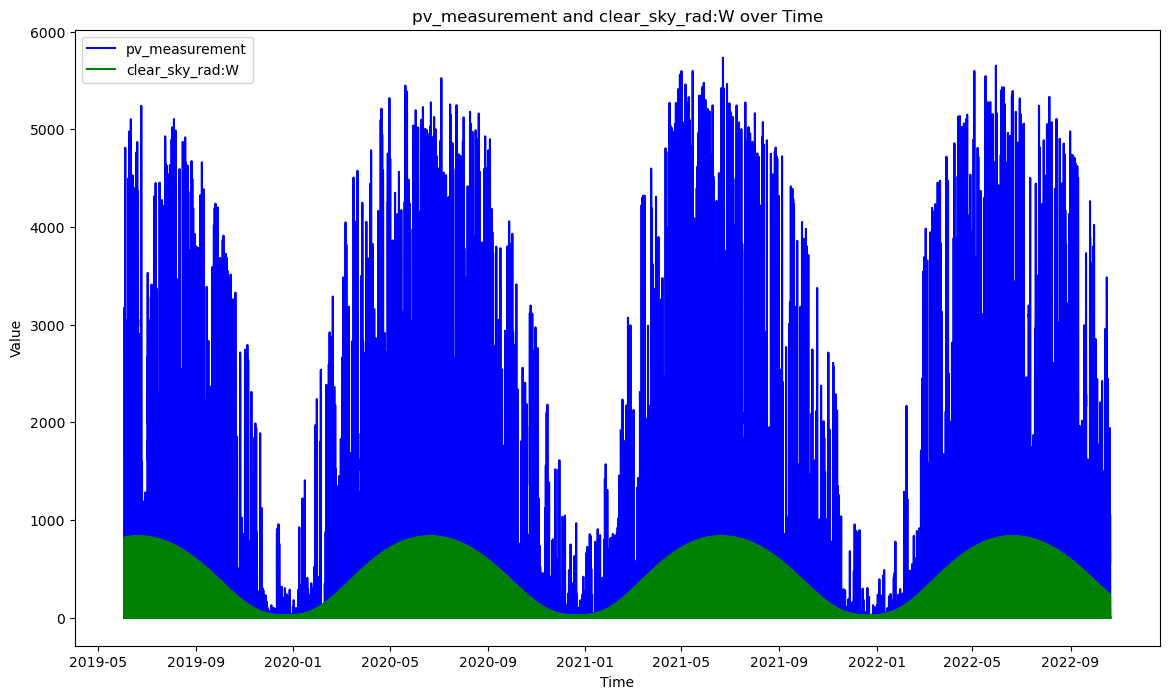

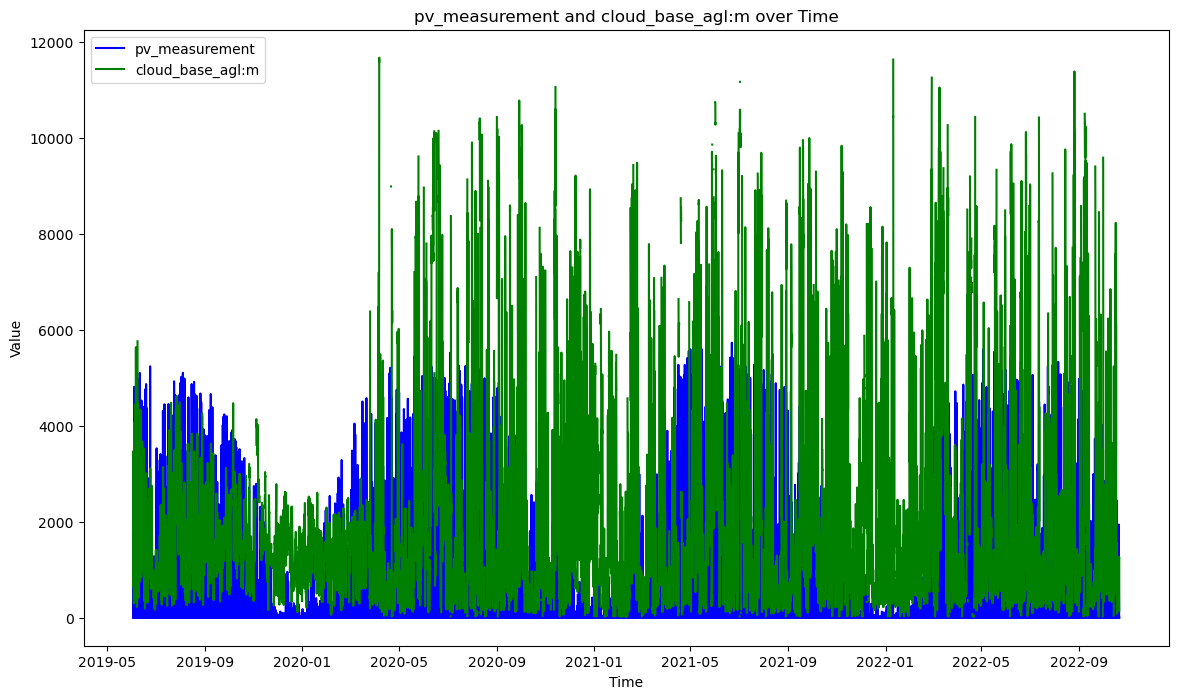

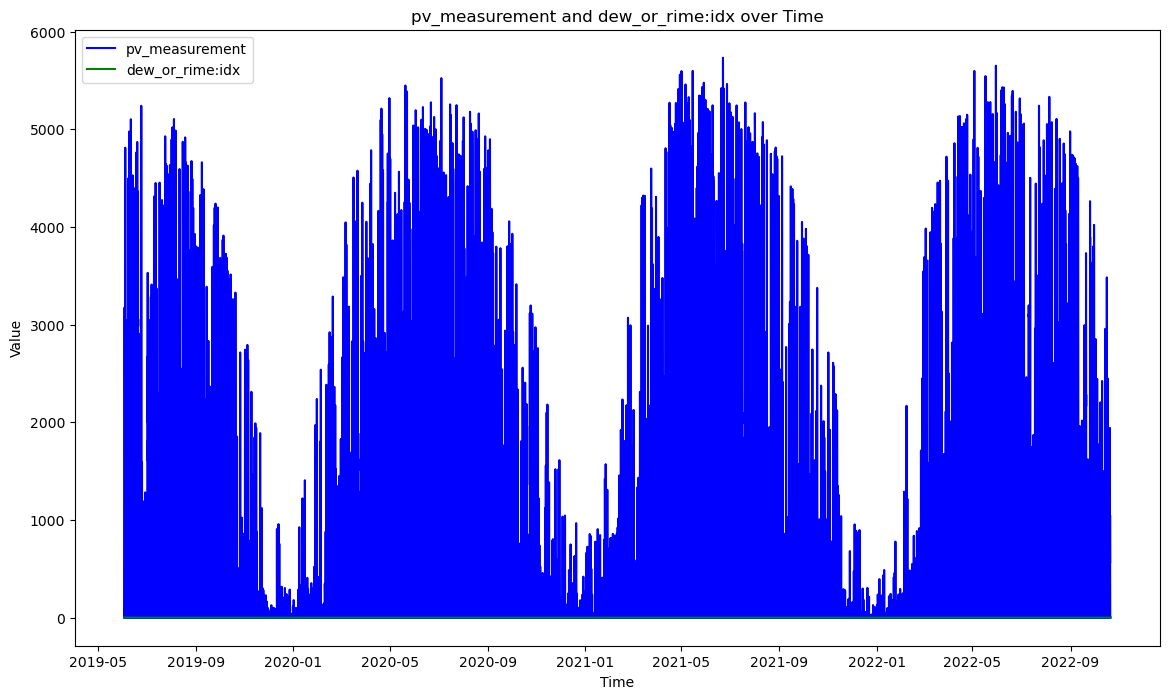

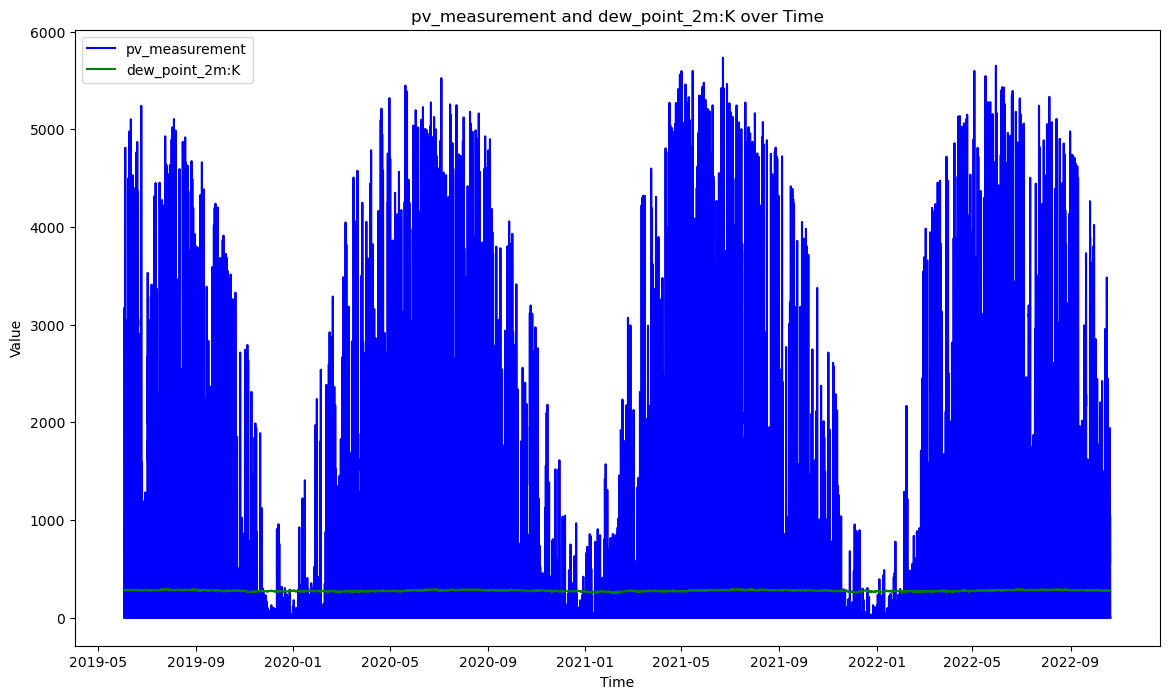

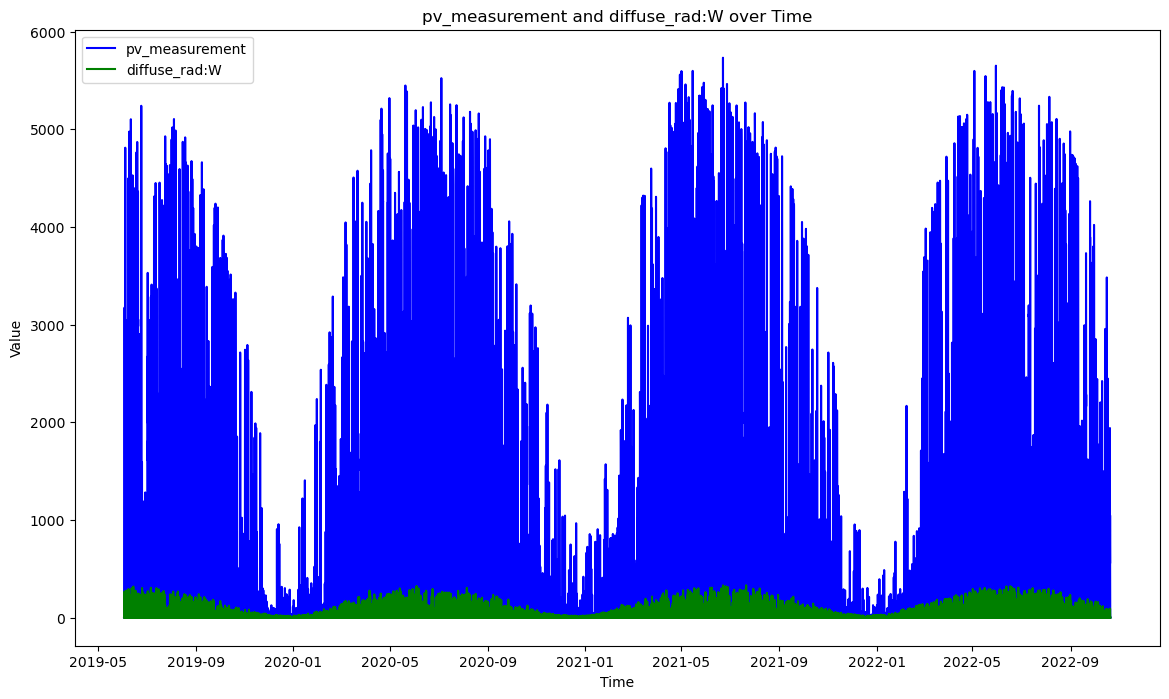

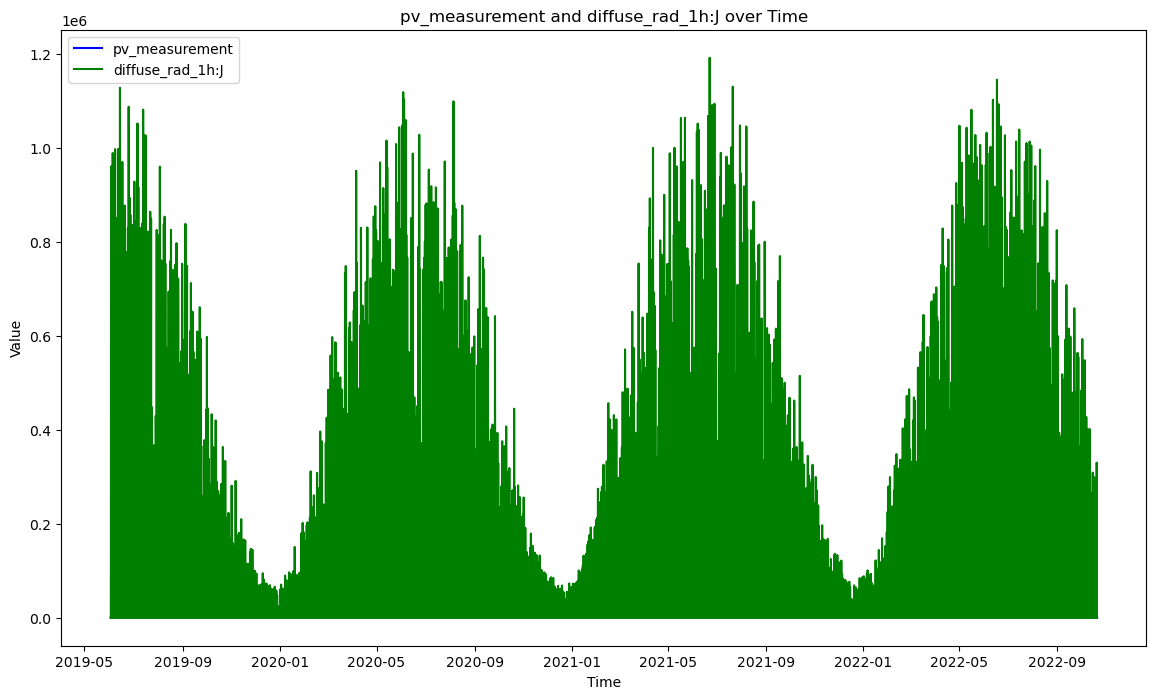

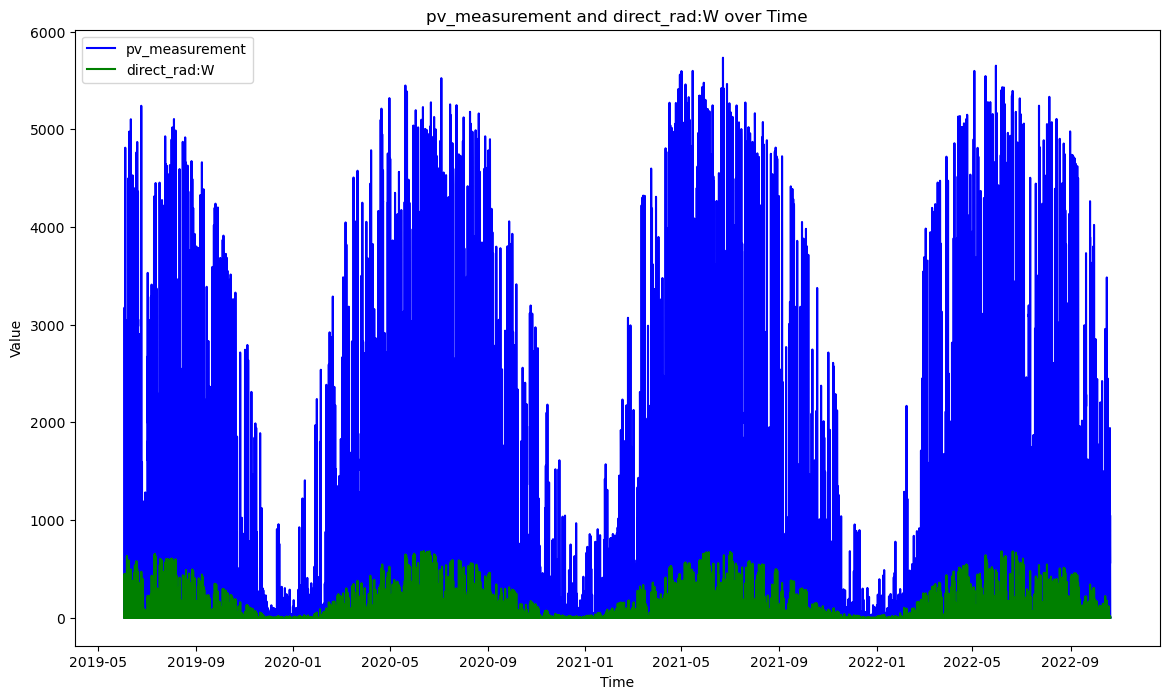

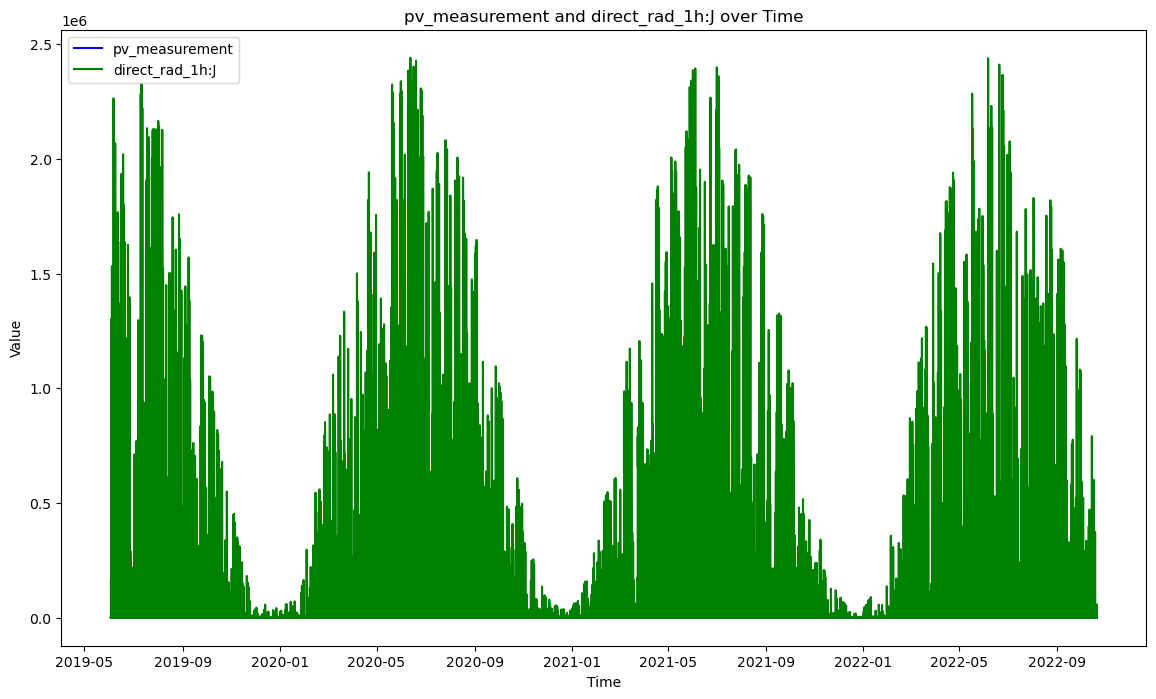

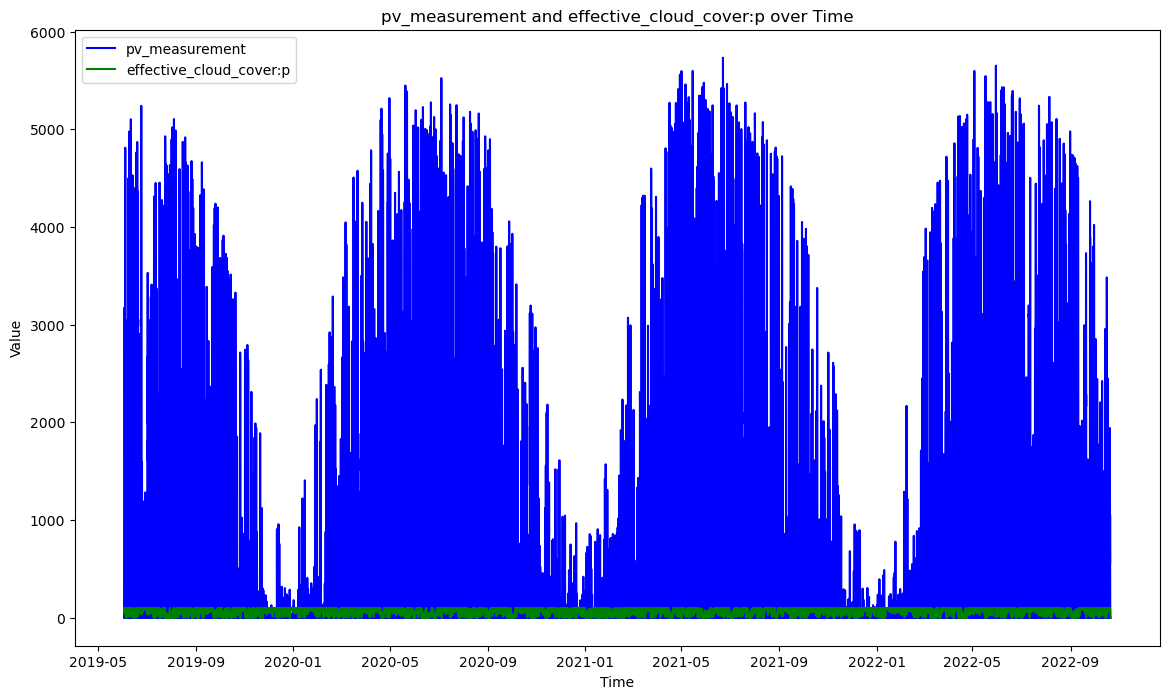

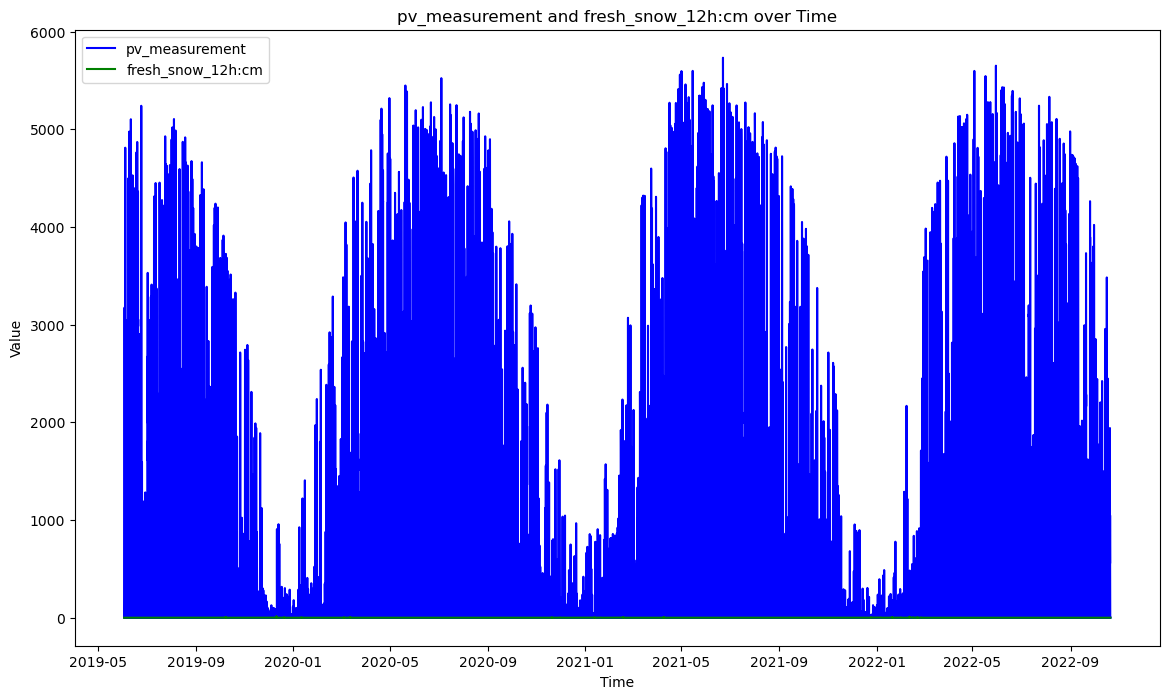

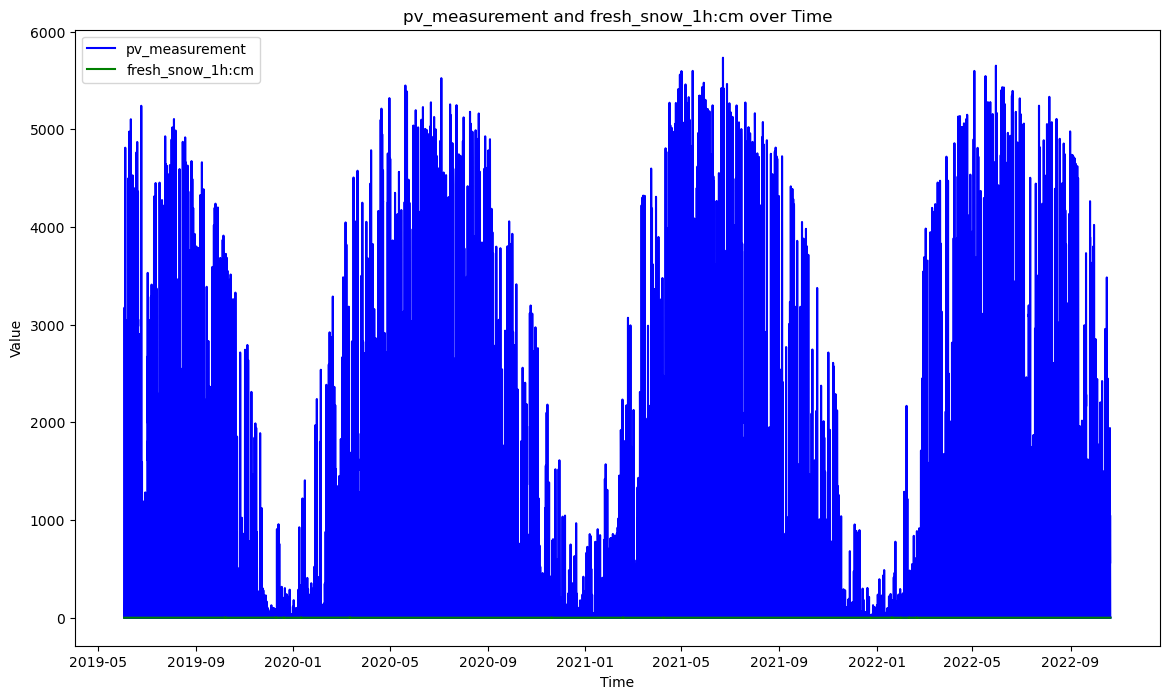

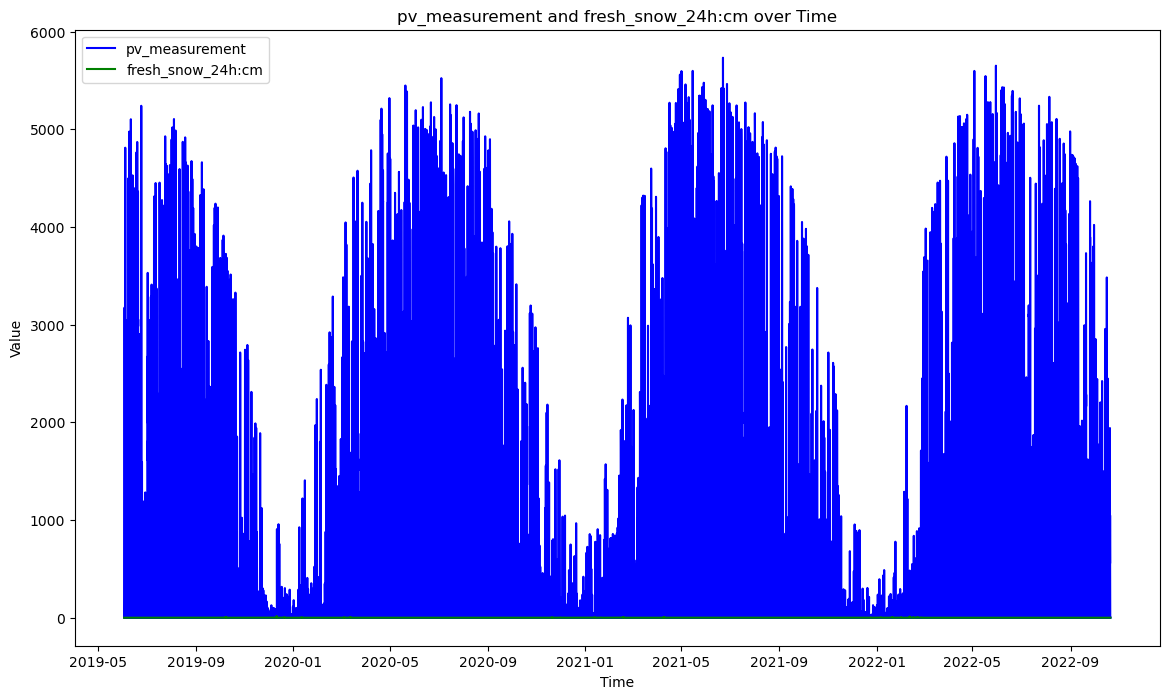

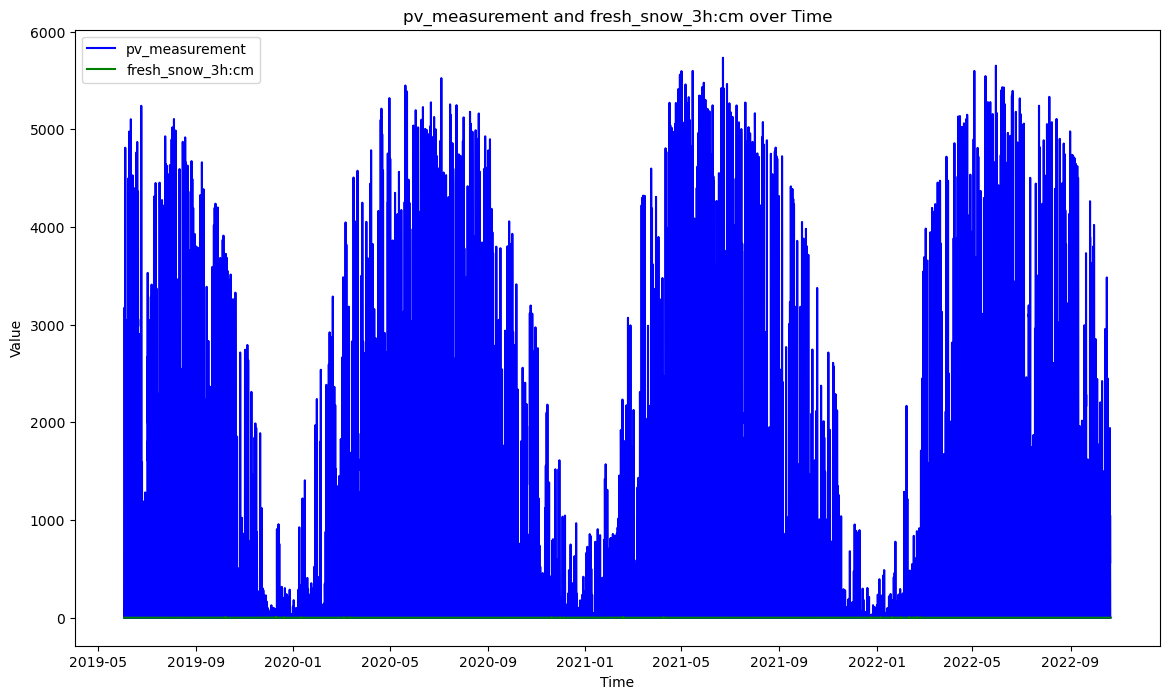

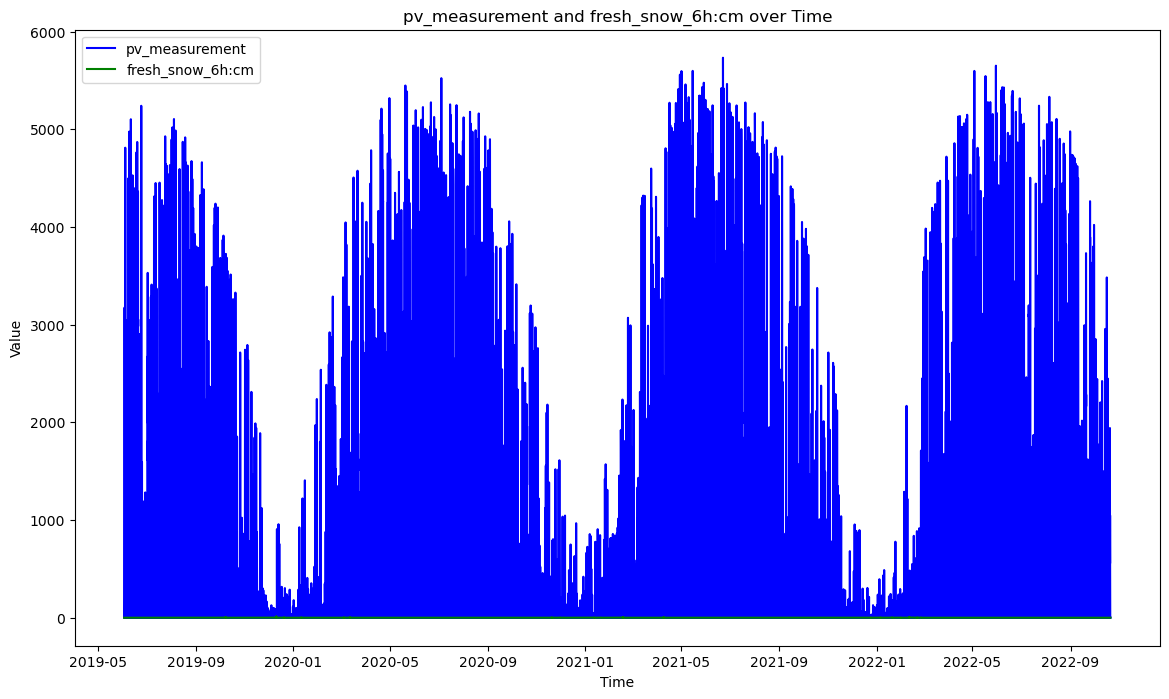

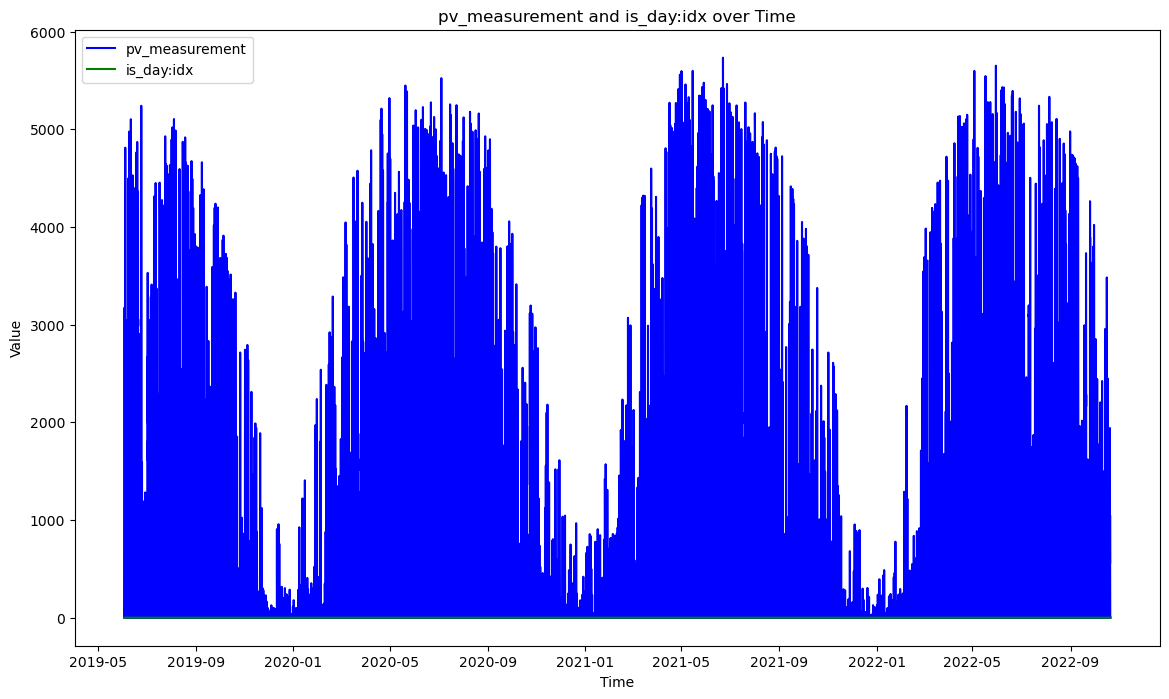

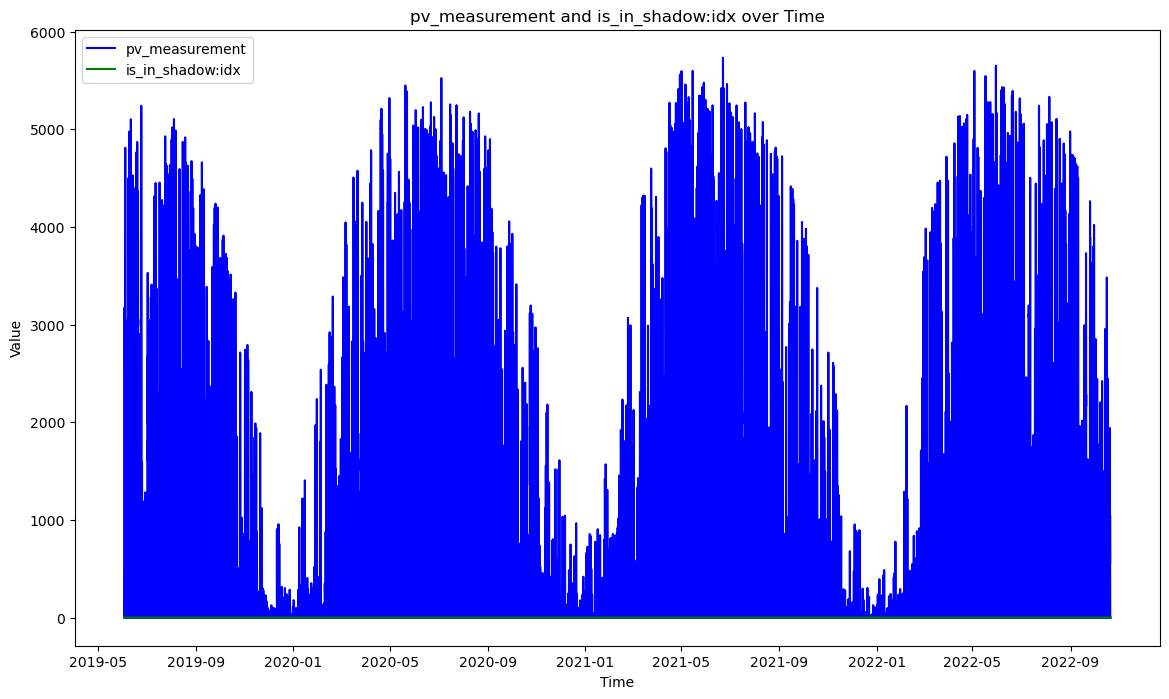

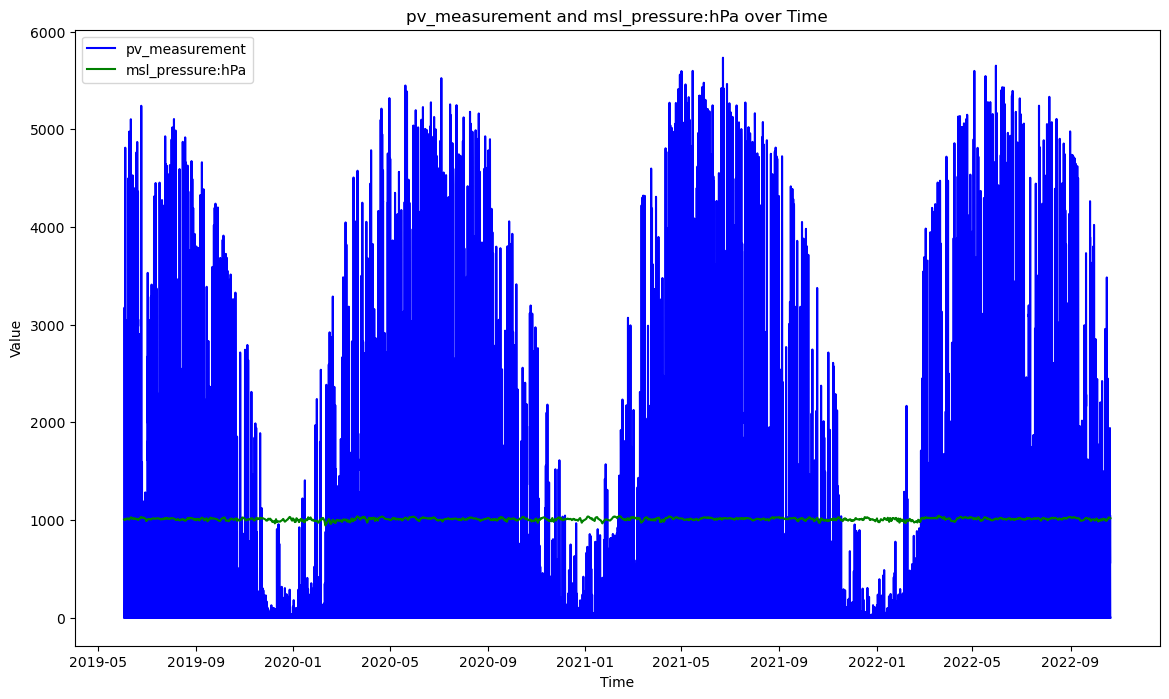

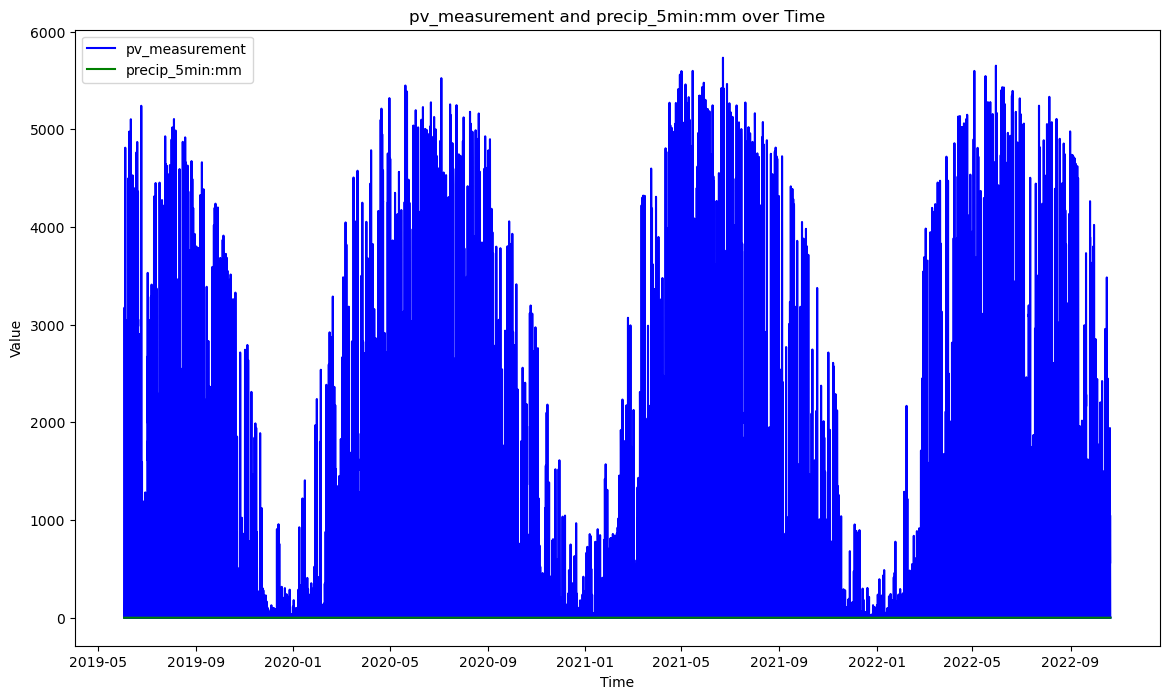

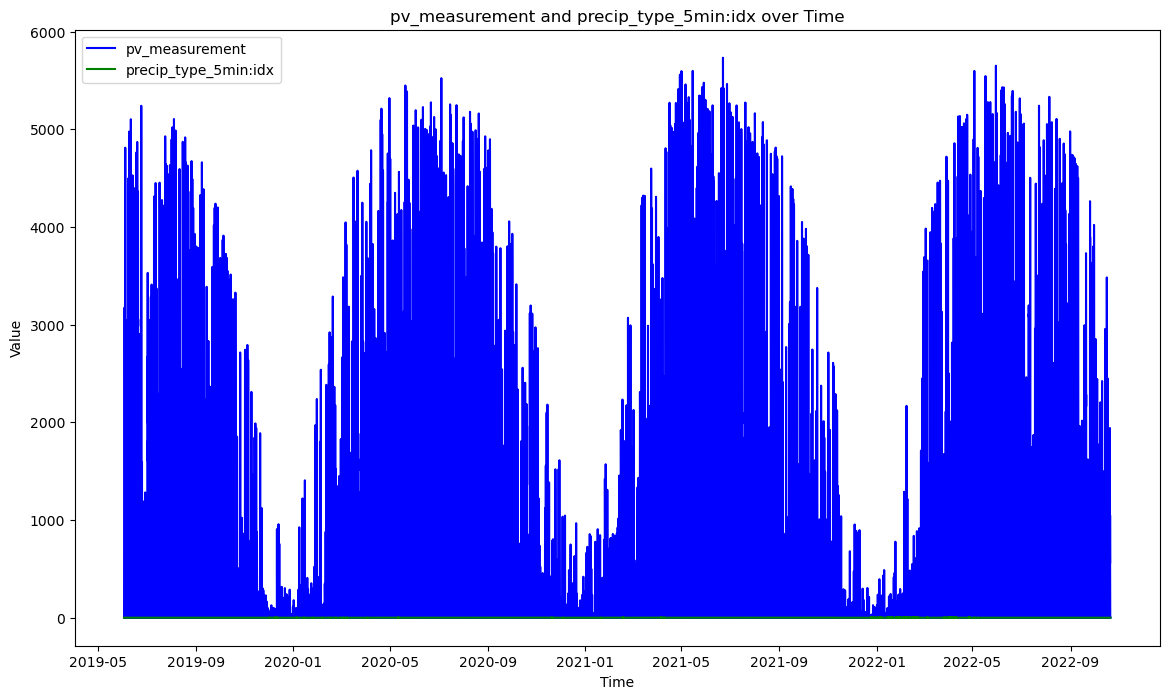

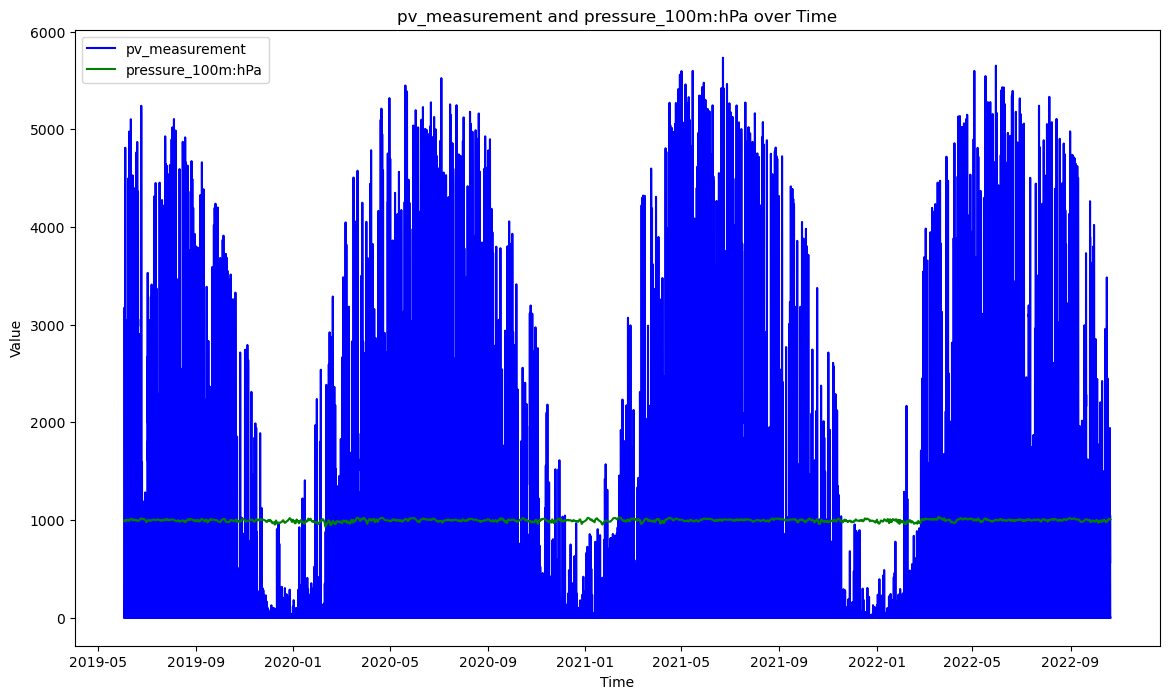

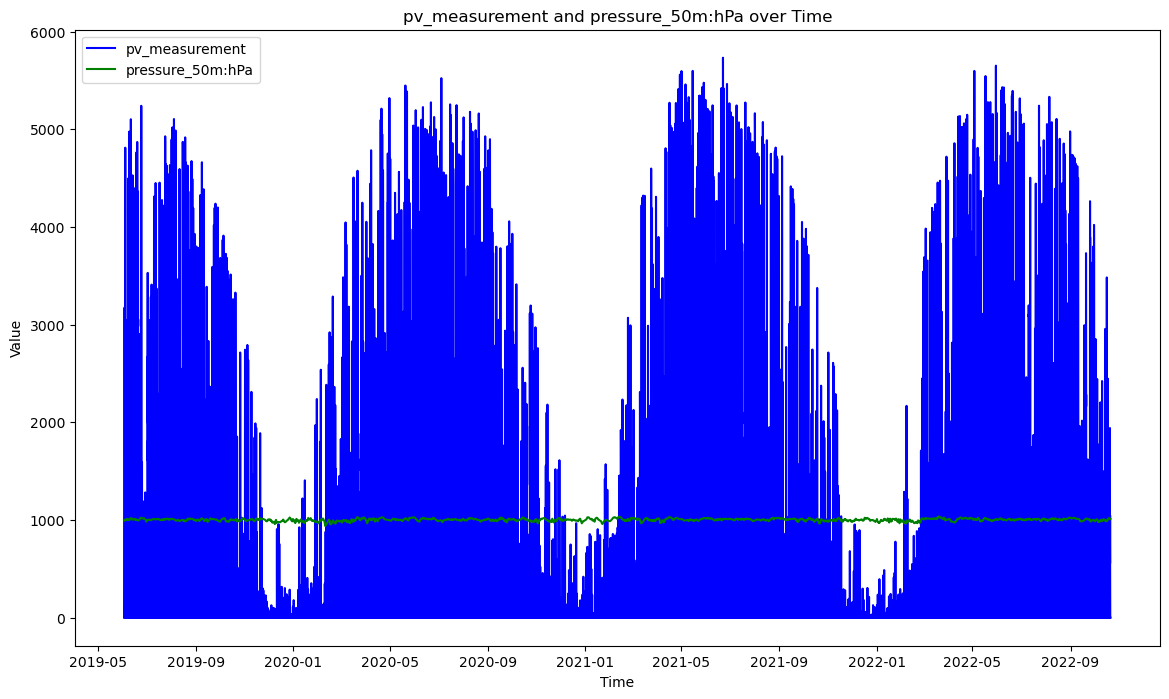

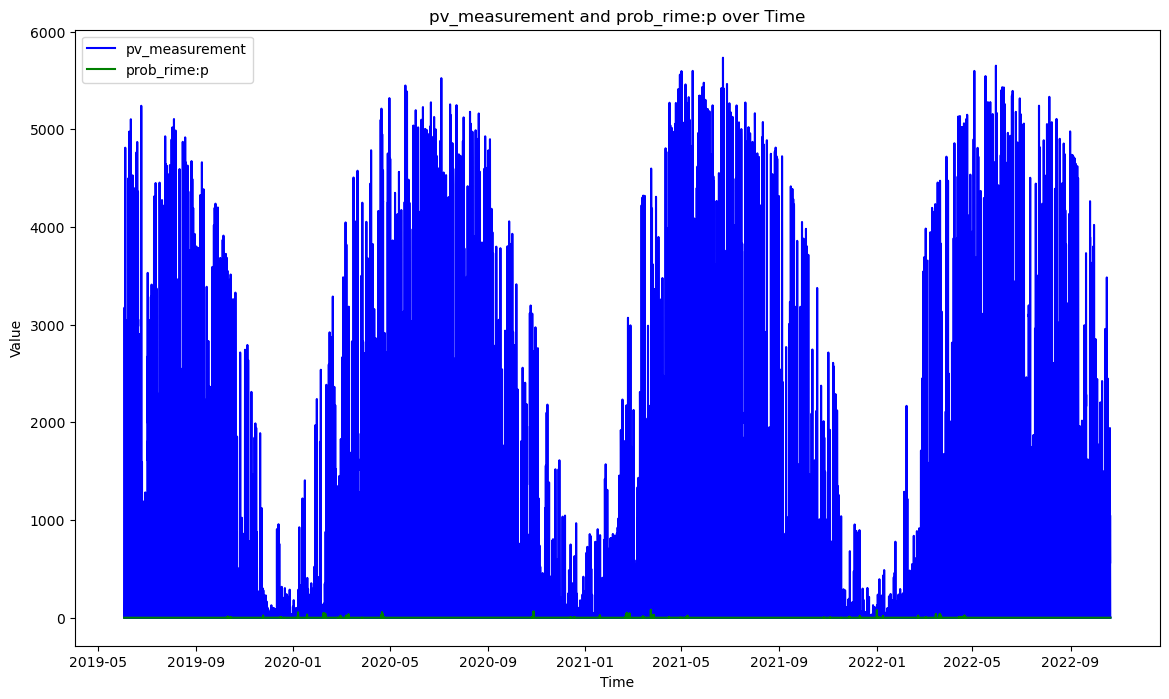

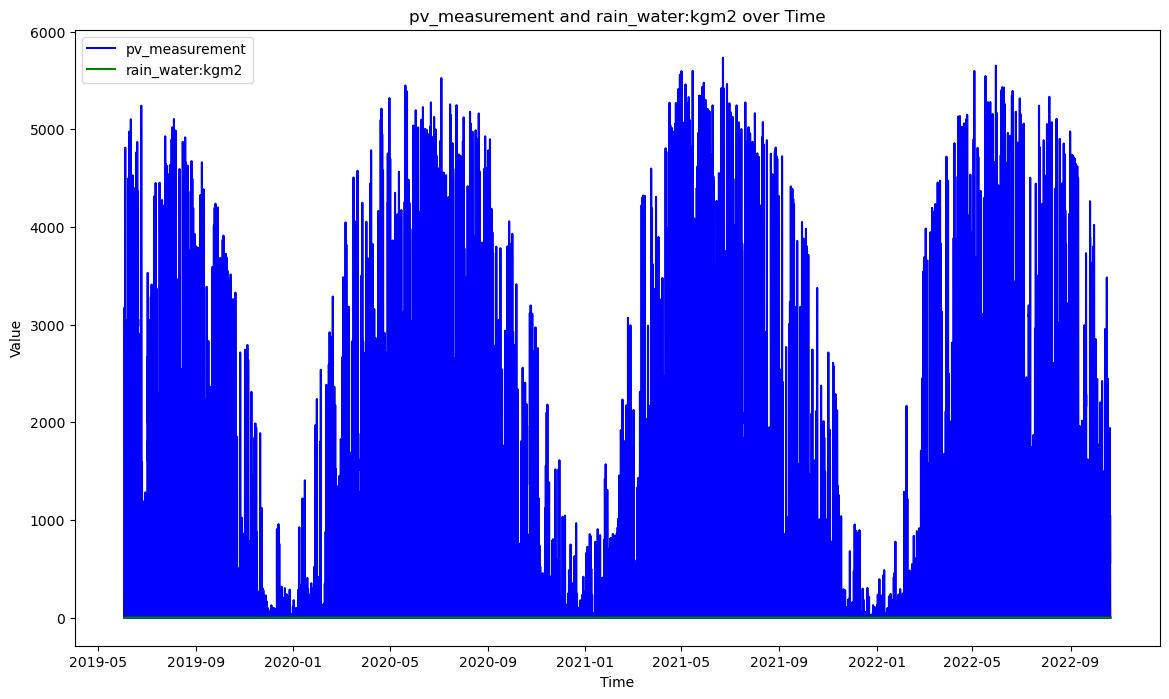

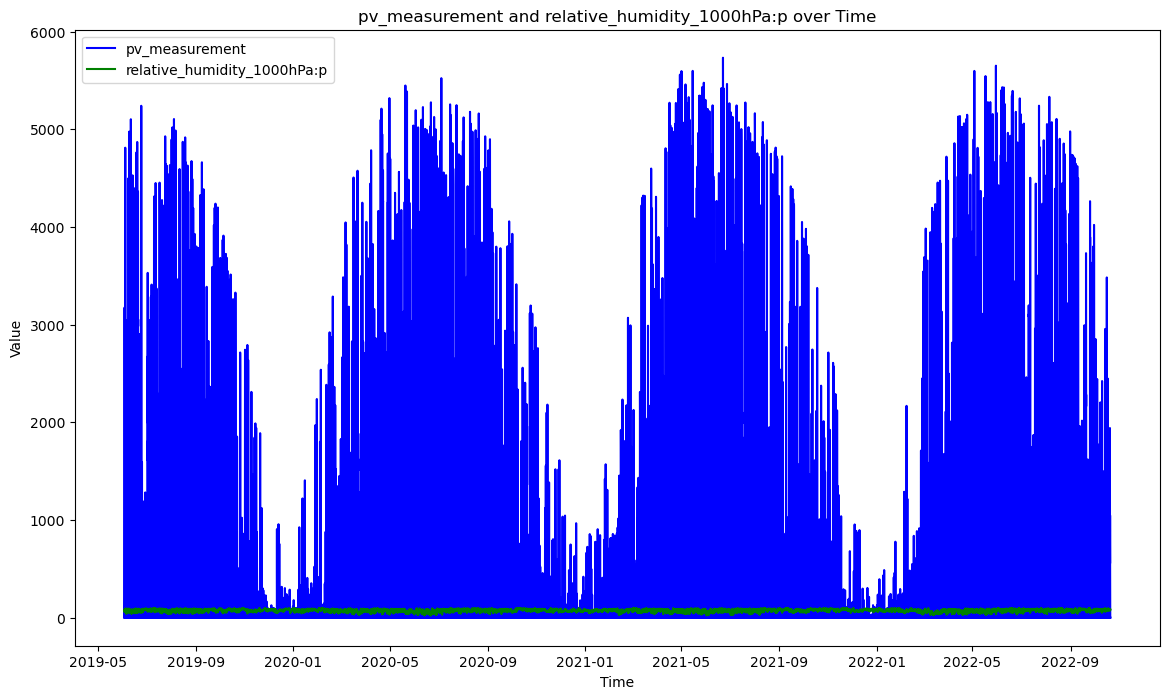

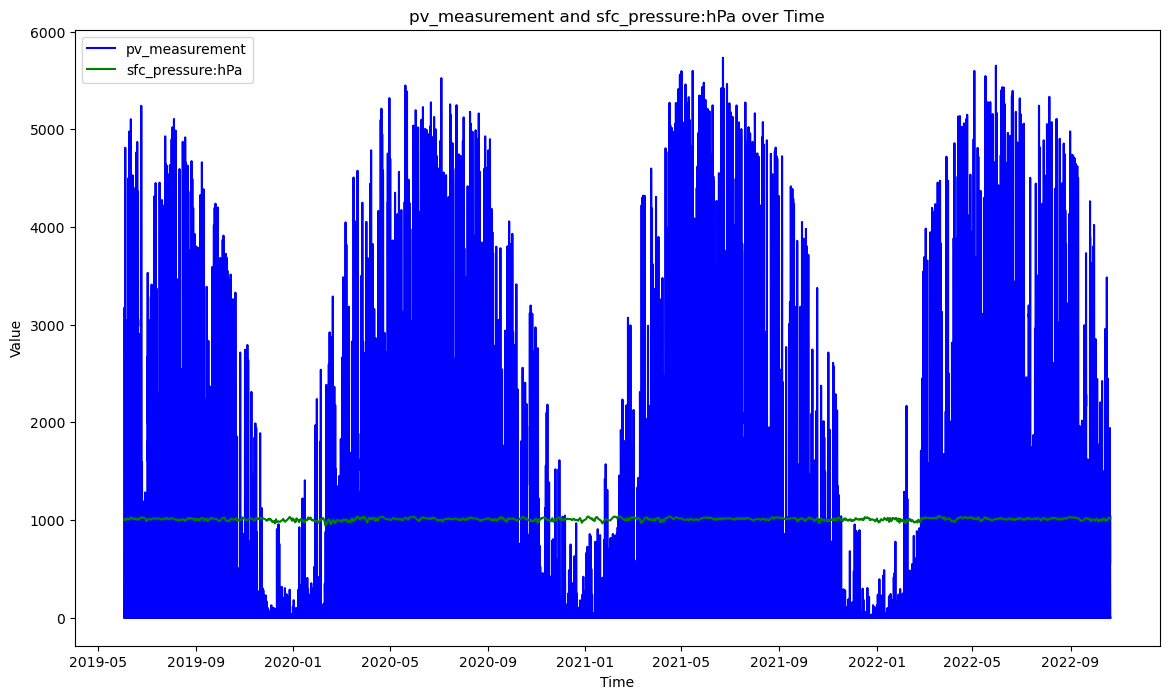

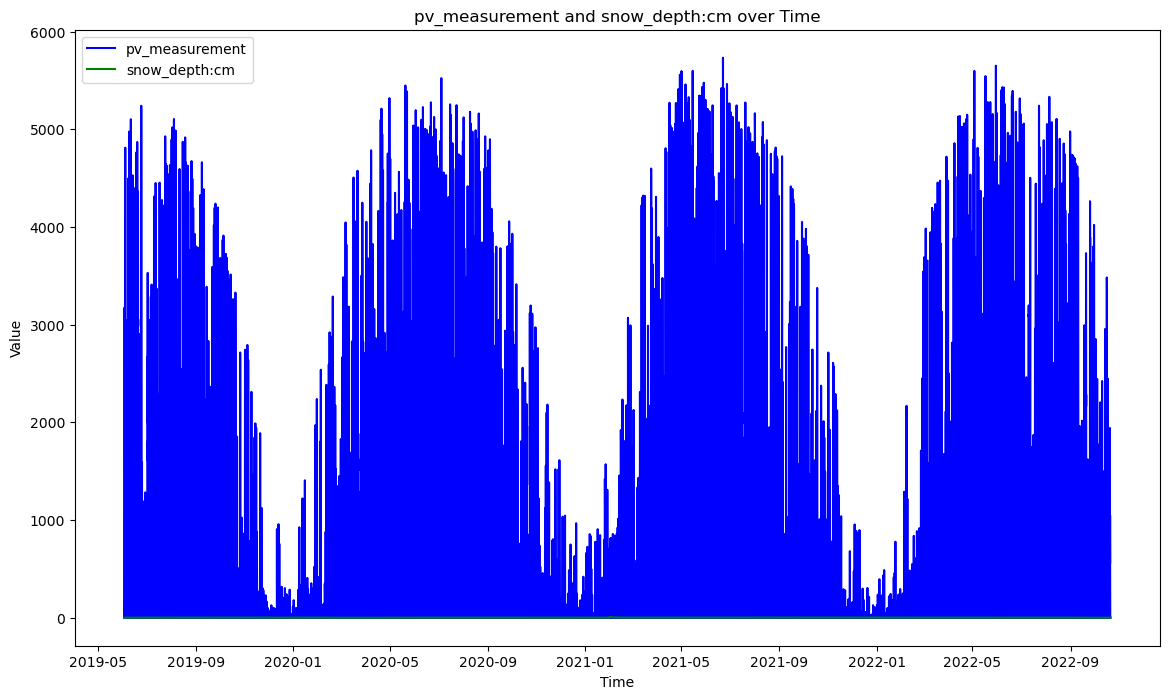

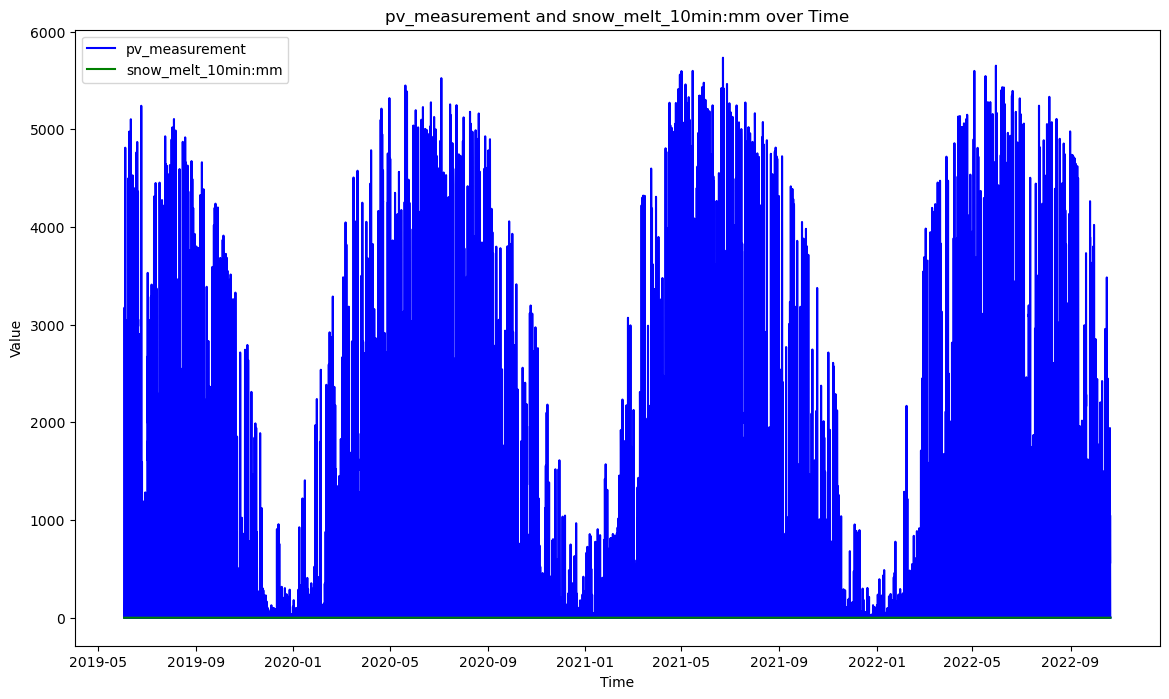

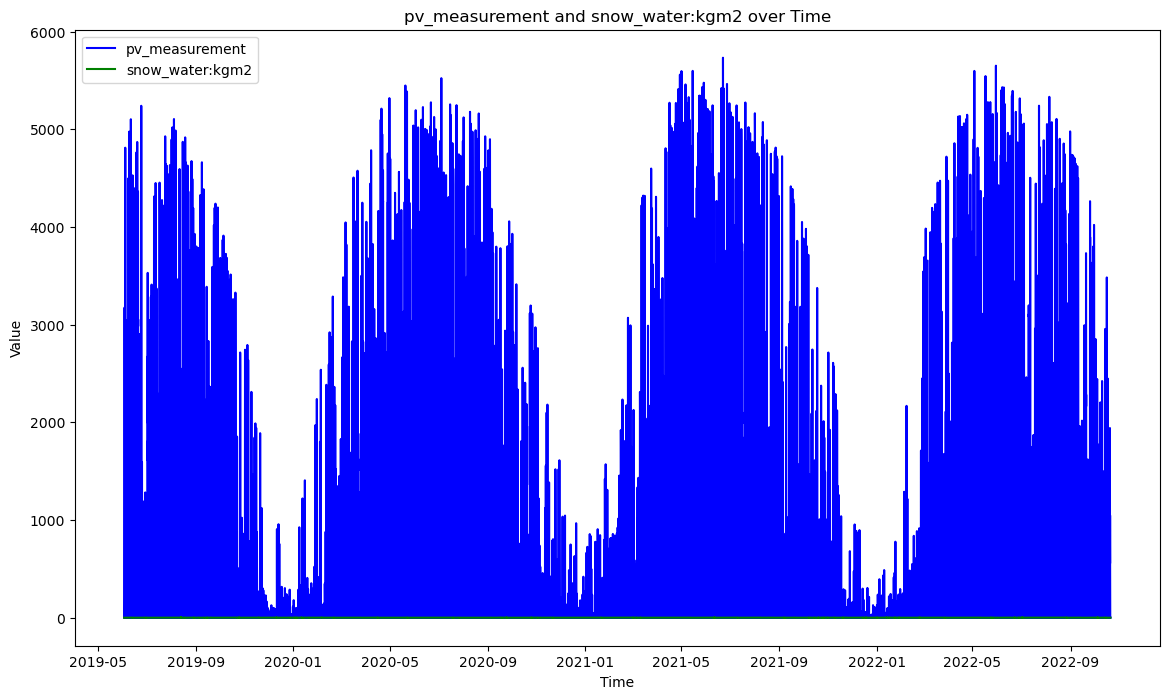

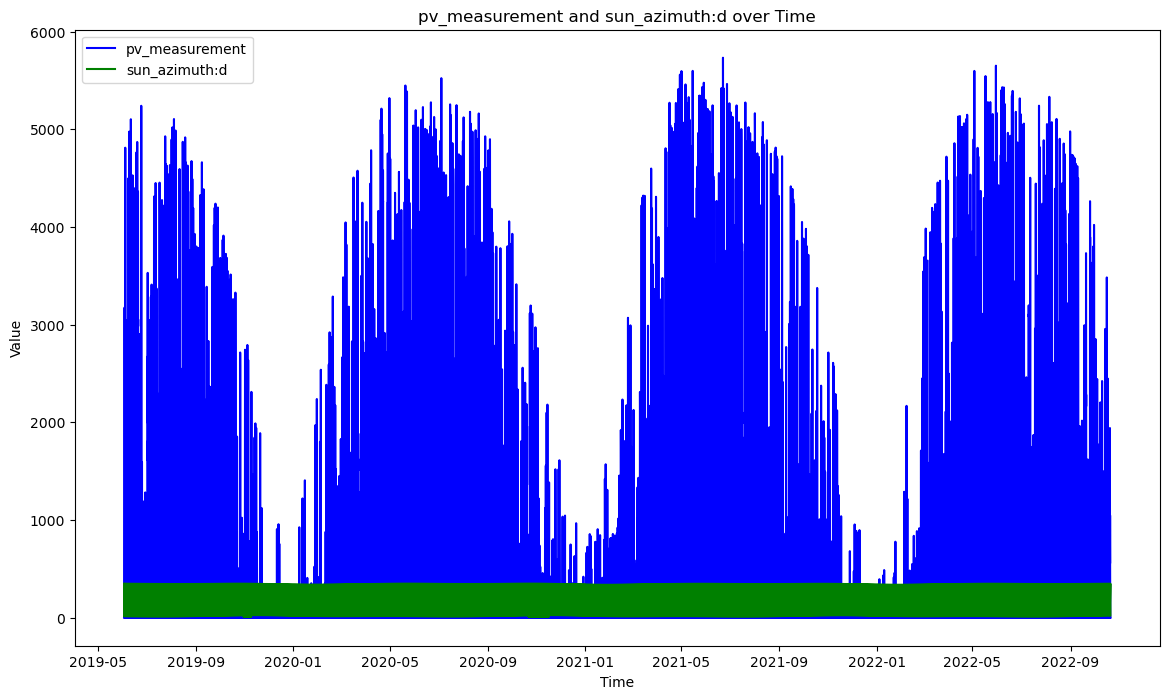

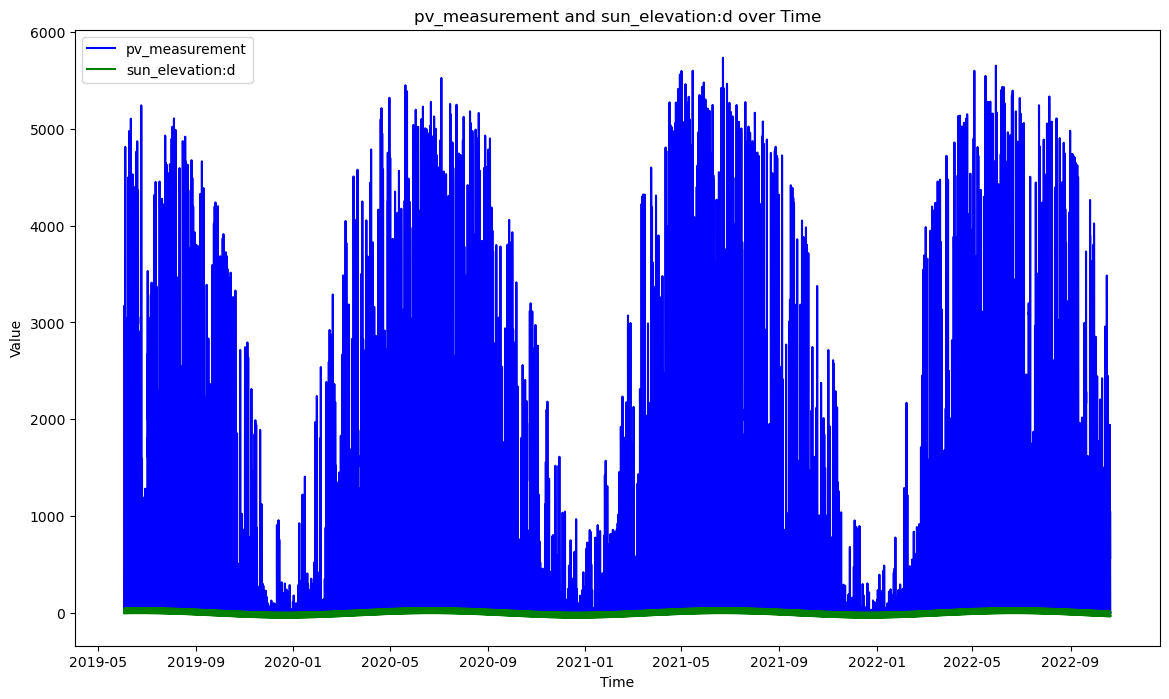

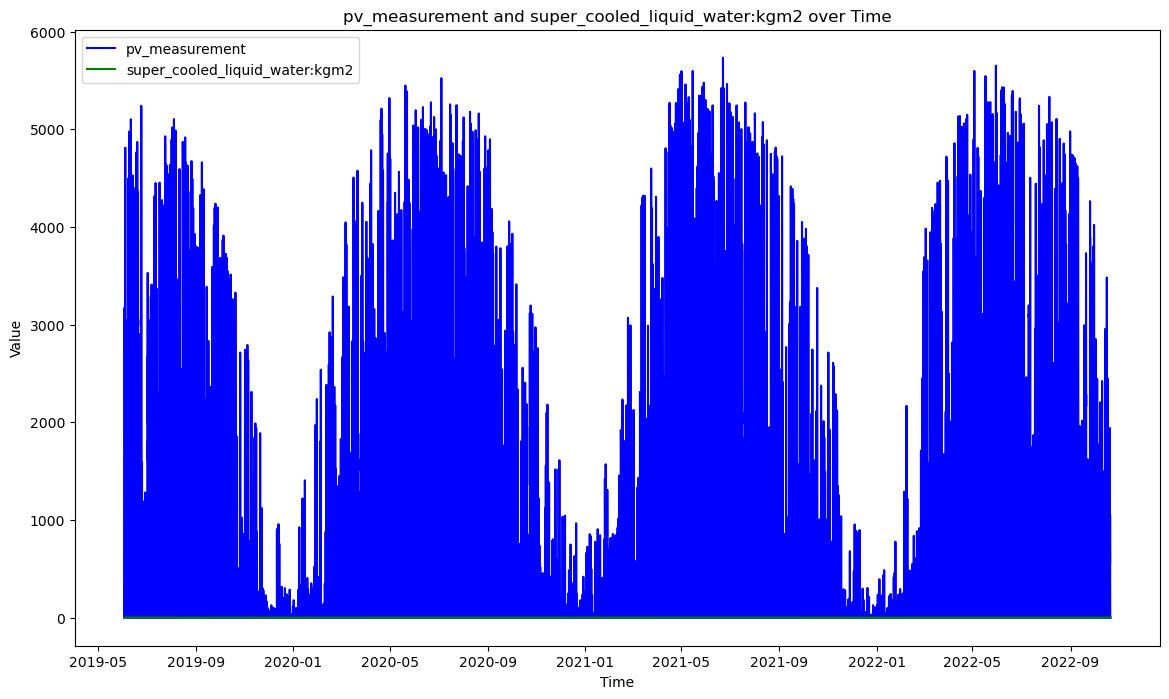

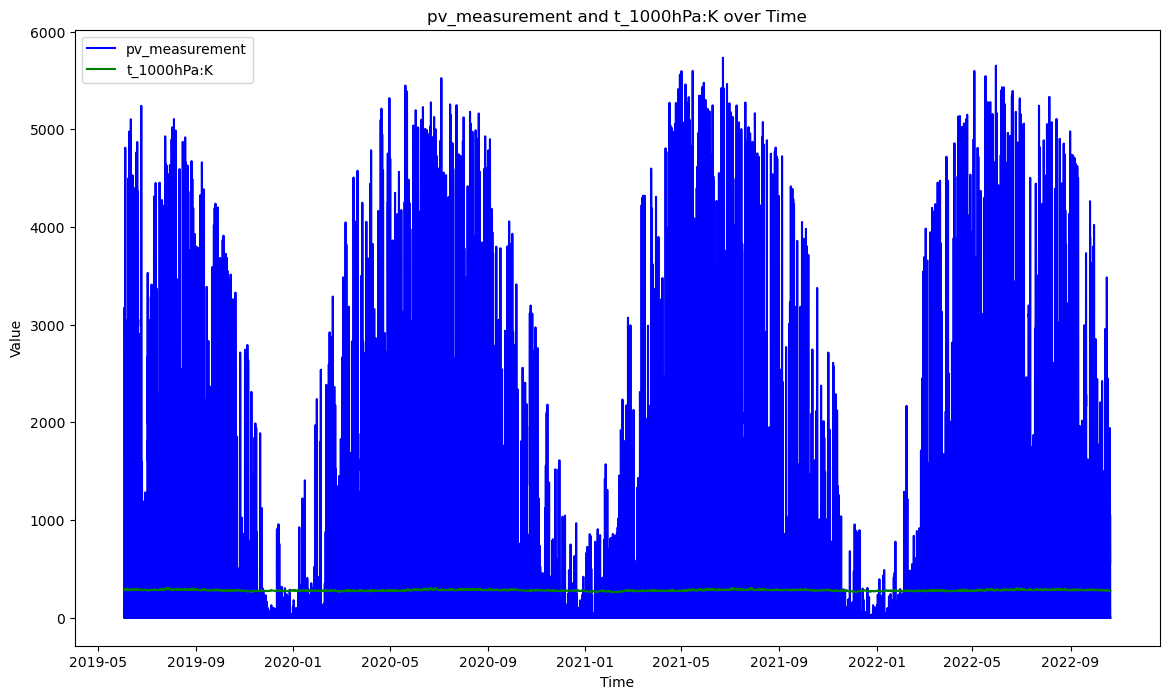

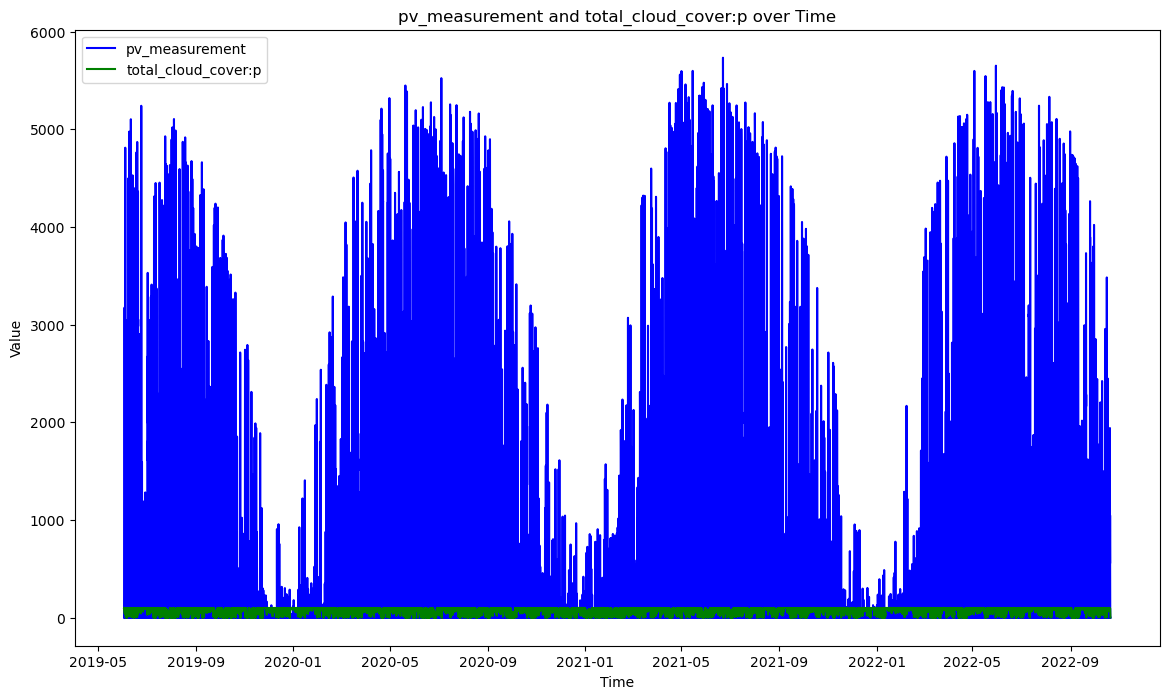

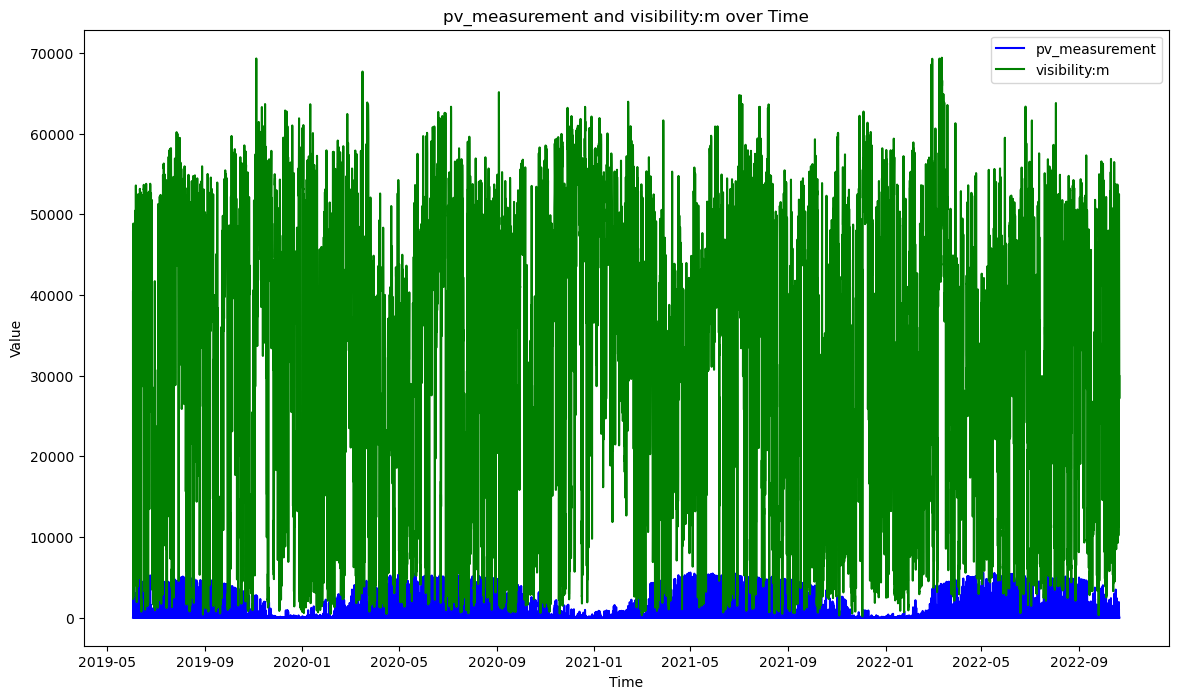

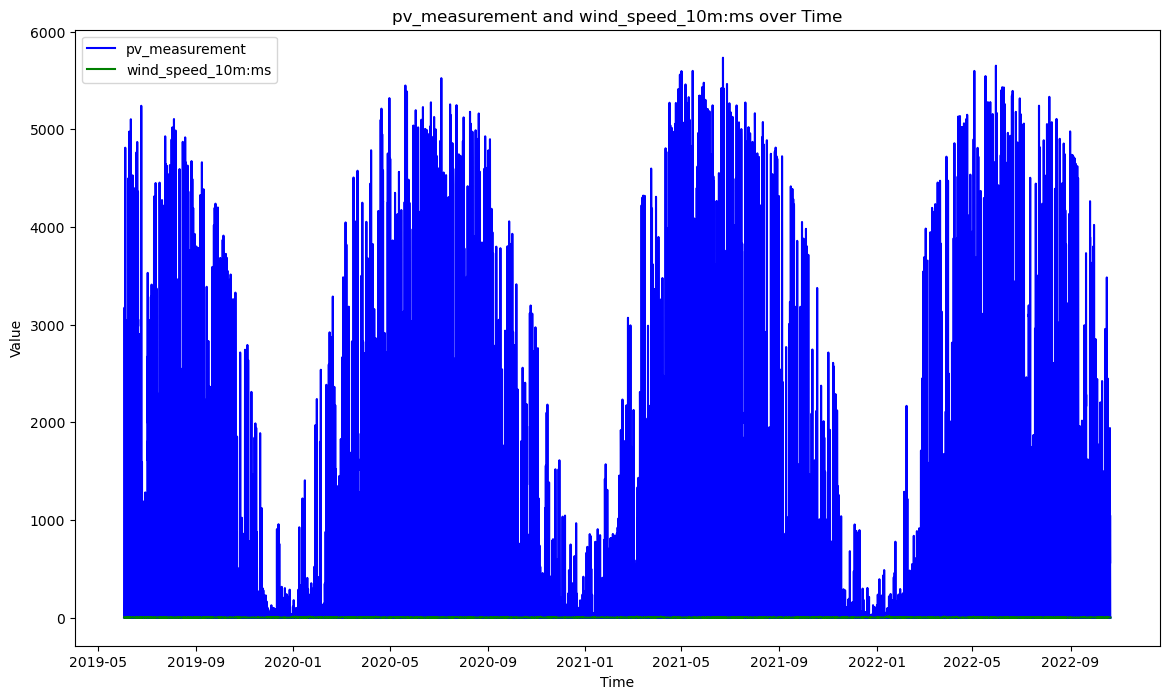

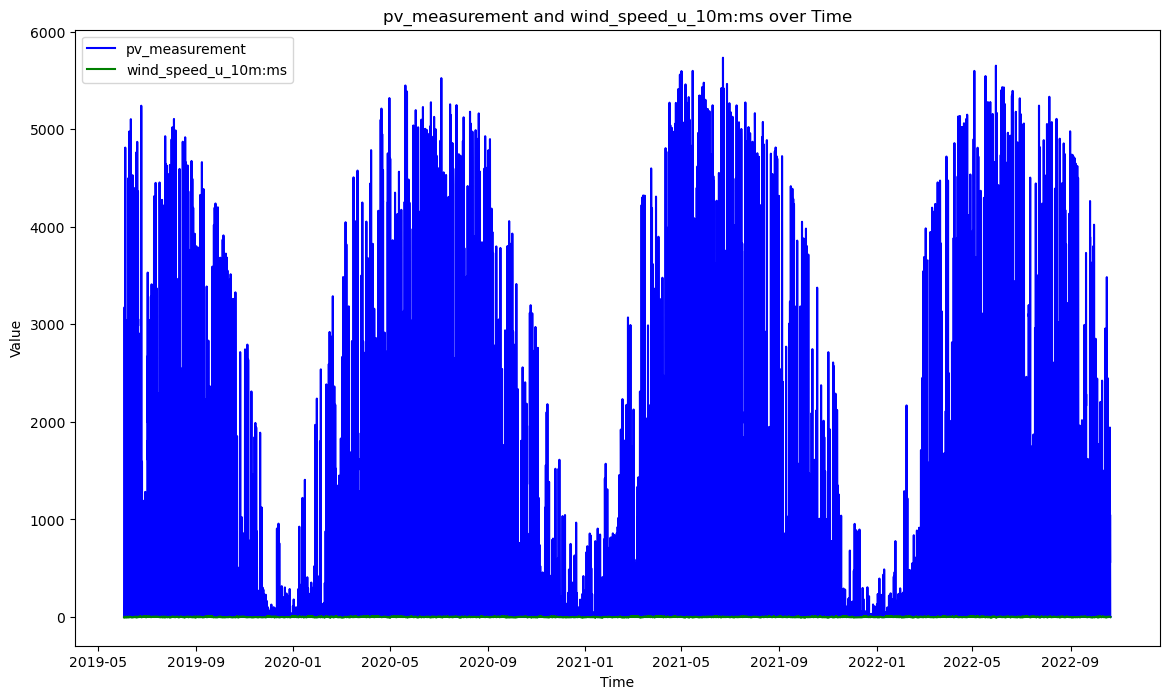

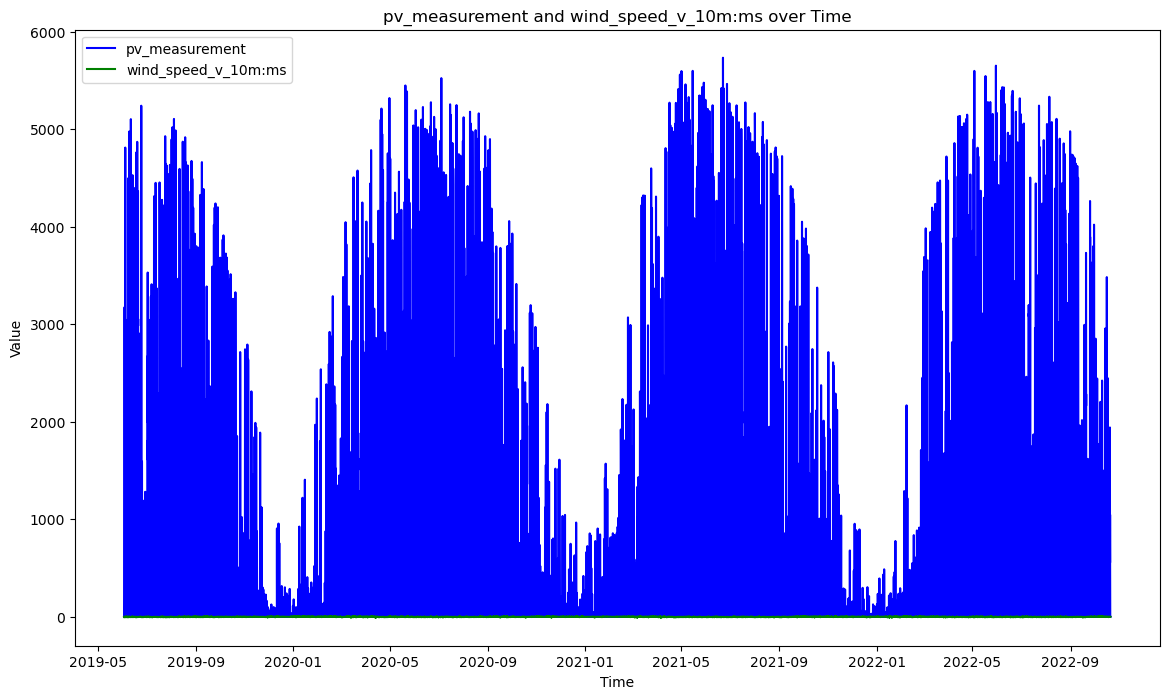

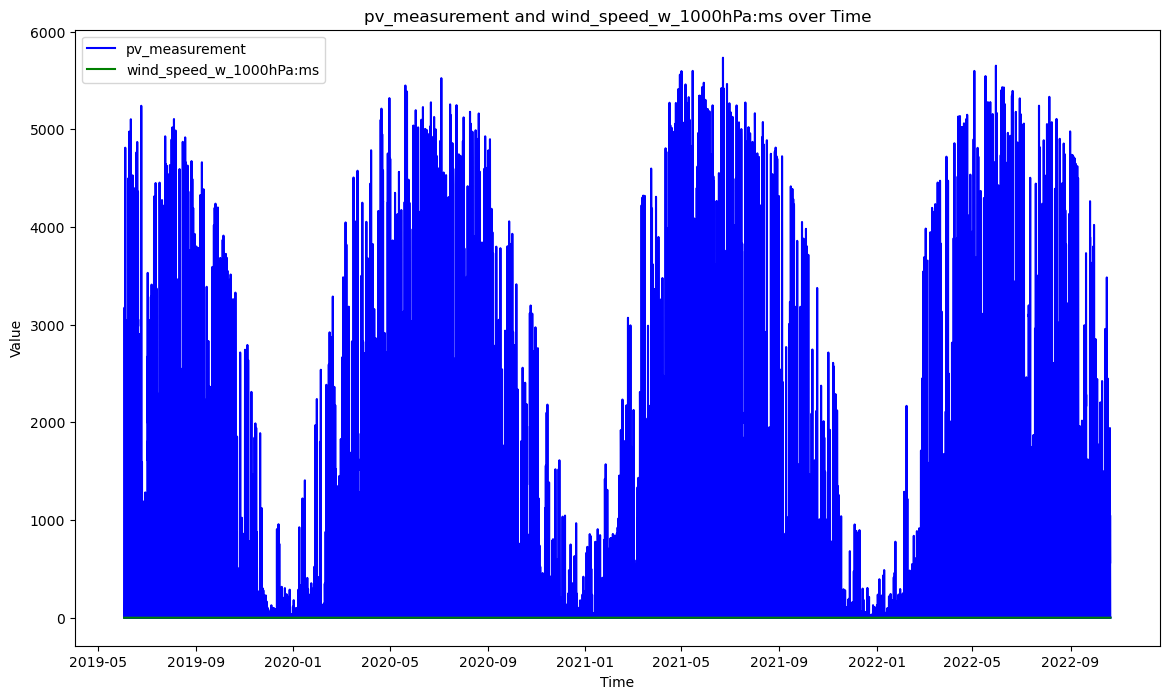

In [18]:

import matplotlib.pyplot as plt

# List of feature columns
feature_columns = filtered_real_data.columns.tolist()
feature_columns.remove('pv_measurement')  # Remove the target column

# Loop through each feature and plot it along with pv_measurement over time
for feature in feature_columns:
    plt.figure(figsize=(14, 8))
    
    # Plot pv_measurement
    plt.plot(filtered_real_data['date_forecast'], filtered_real_data['pv_measurement'], label='pv_measurement', color='blue')
    
    # Plot the feature
    plt.plot(filtered_real_data['date_forecast'], filtered_real_data[feature], label=feature, color='green')
    
    plt.title(f'pv_measurement and {feature} over Time')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



In [19]:
# Filter rows where the absolute value of correlation is greater than 0.5
filtered_corr = real_corr_with_target[real_corr_with_target['pv_measurement'].abs() > 0.5]

# Sort the filtered DataFrame by 'pv_measurement' in ascending order (not in absolute values)
sorted_filtered_corr = filtered_corr.sort_values(by='pv_measurement', ascending=True)

# Now, sorted_filtered_corr contains the correlations you're interested in
print(sorted_filtered_corr)

                       pv_measurement
is_in_shadow:idx            -0.586869
is_day:idx                   0.554569
sun_elevation:d              0.695713
diffuse_rad_1h:J             0.703887
diffuse_rad:W                0.711396
clear_sky_energy_1h:J        0.799407
clear_sky_rad:W              0.812047
direct_rad_1h:J              0.850497
direct_rad:W                 0.864334


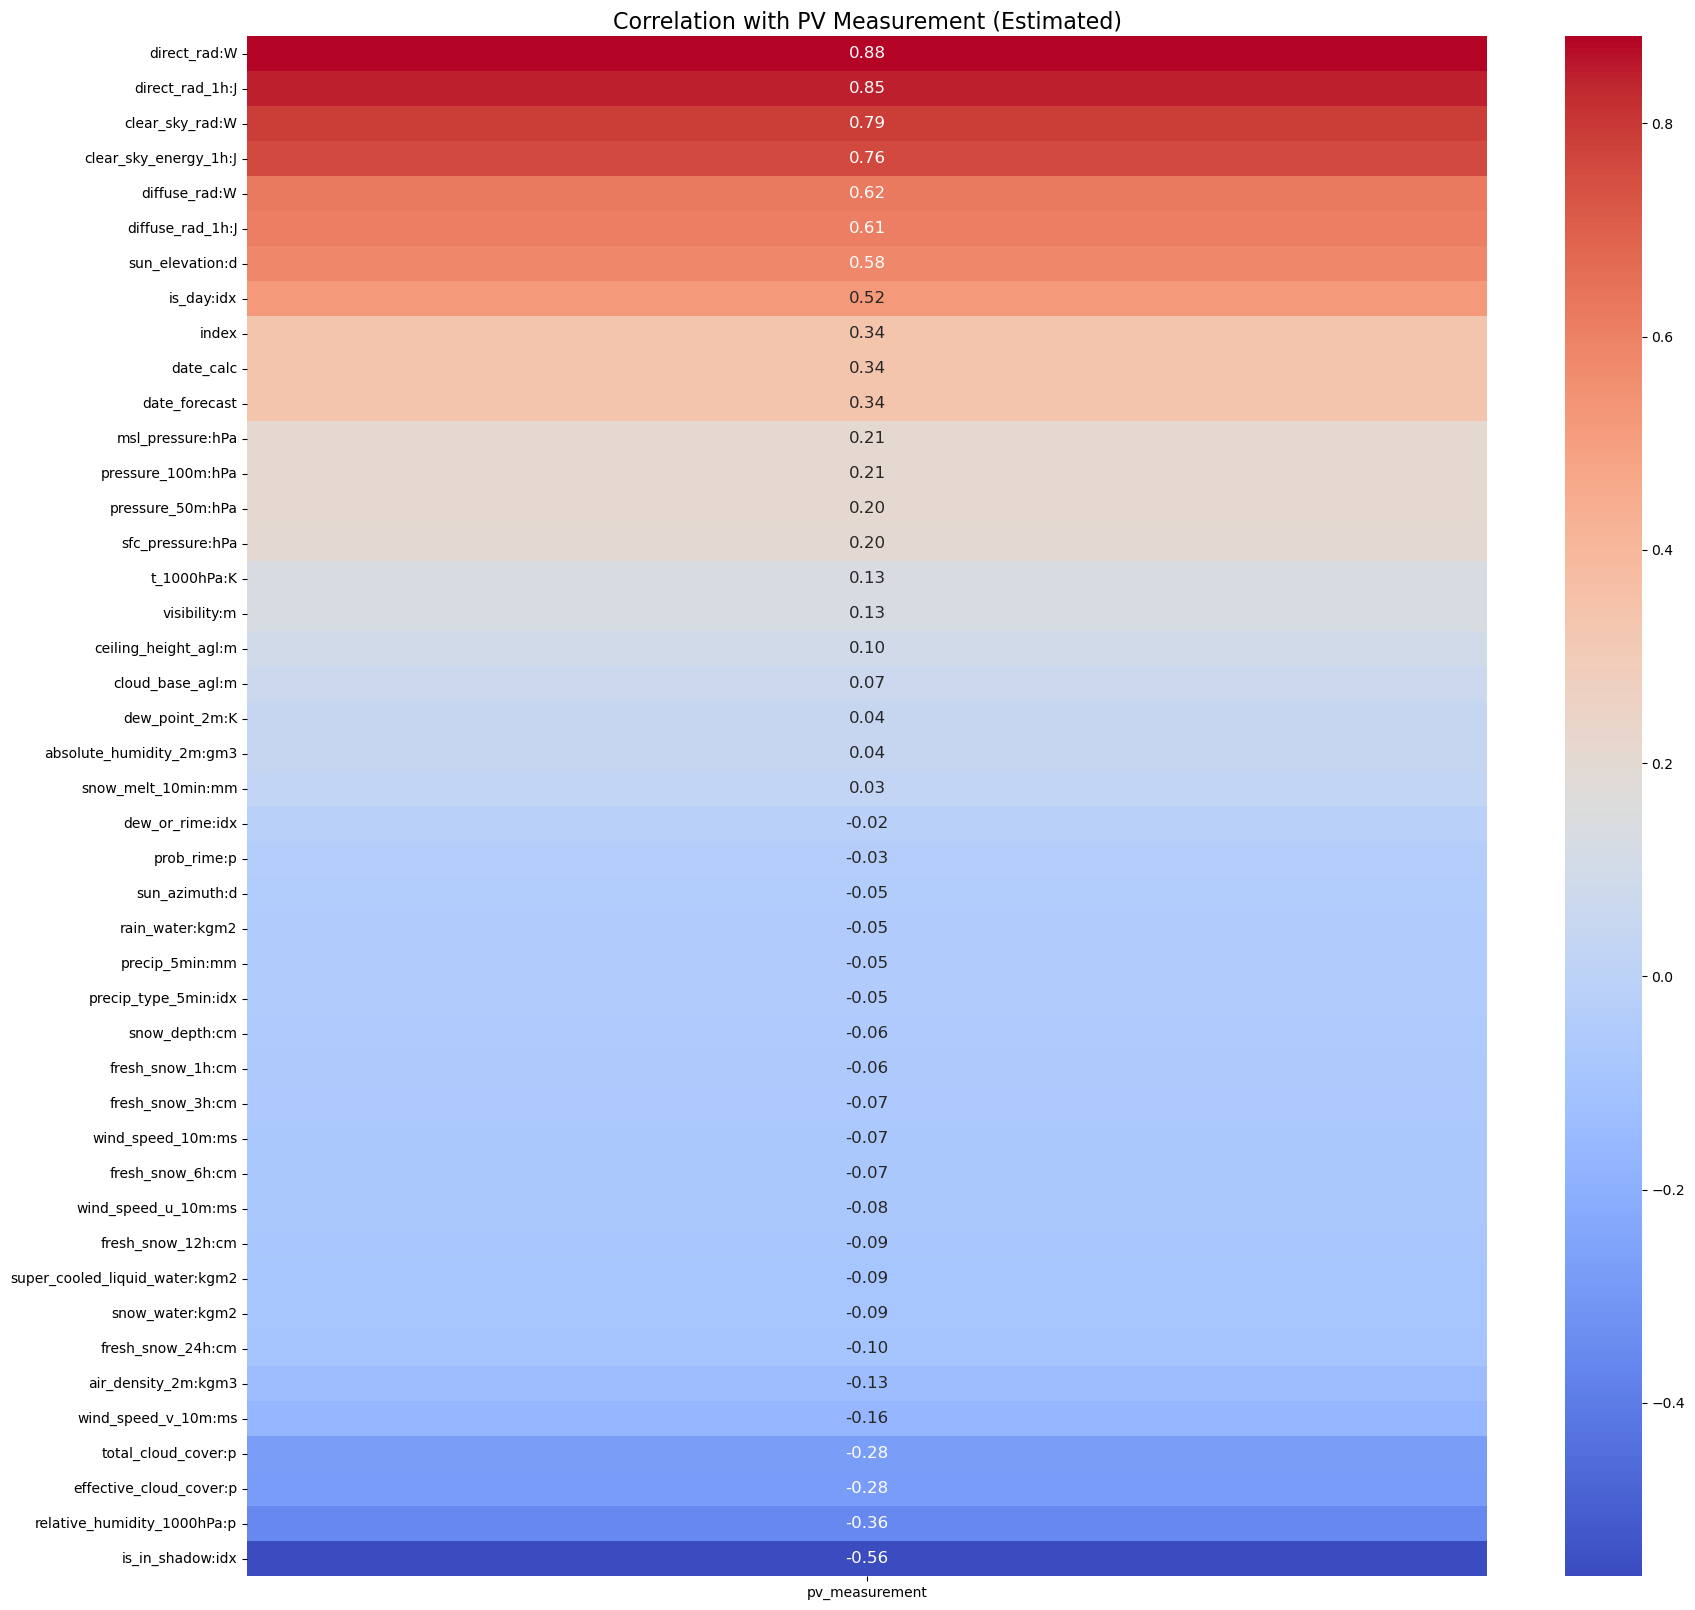

In [20]:
# If x_train_estimated has a 'date_forecast' field and needs to be grouped
# X_train_estimated_1hr = x_train_estimated.groupby(pd.Grouper(key='date_forecast', freq='1H')).mean()

# Merge DataFrames
estimated_data = pd.merge(train_targets, X_train_estimated.reset_index(), on='date_forecast')  # Make sure to reset the index

estimated_data.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'wind_speed_w_1000hPa:ms'], inplace=True)
# Calculate Correlation
estimated_corr = estimated_data.corr()

# Filter to only include correlation with 'pv_measurement'
estimated_corr_with_target = estimated_corr[['pv_measurement']].sort_values(by='pv_measurement', ascending=False)
estimated_corr_with_target = estimated_corr_with_target.drop(index='pv_measurement')

# print(estimated_corr_with_target)


# Plot Heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(estimated_corr_with_target, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title("Correlation with PV Measurement (Estimated)", fontsize=16)
plt.show()


In [21]:
# Filter rows where the absolute value of correlation is greater than 0.5
filtered_corr = estimated_corr_with_target[estimated_corr_with_target['pv_measurement'].abs() > 0.5]

# Sort the filtered DataFrame by 'pv_measurement' in ascending order (not in absolute values)
sorted_filtered_corr = filtered_corr.sort_values(by='pv_measurement', ascending=True)

# Now, sorted_filtered_corr contains the correlations you're interested in
print(sorted_filtered_corr)

                       pv_measurement
is_in_shadow:idx            -0.562579
is_day:idx                   0.517589
sun_elevation:d              0.580583
diffuse_rad_1h:J             0.605870
diffuse_rad:W                0.622477
clear_sky_energy_1h:J        0.759709
clear_sky_rad:W              0.787613
direct_rad_1h:J              0.847495
direct_rad:W                 0.881677


Number of zeroes: 13613
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
13607         1
13608         1
13609         1
13610         1
13611         1

[13612 rows x 1 columns]


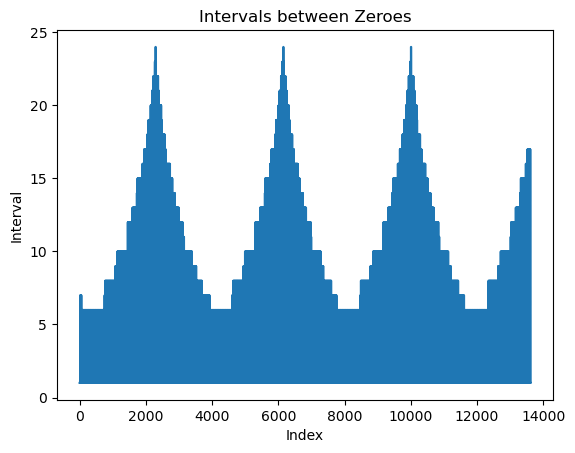

In [22]:
zero_count = (filtered_real_data['is_in_shadow:idx'] == 0).sum()
print(f"Number of zeroes: {zero_count}")

# Find the intervals where zeroes appear
zero_indices = filtered_real_data.index[filtered_real_data['is_in_shadow:idx'] == 0].tolist()

# Calculate intervals between zero occurrences
zero_intervals = [zero_indices[i+1] - zero_indices[i] for i in range(len(zero_indices)-1)]

# Convert to DataFrame for better visualization
zero_intervals_df = pd.DataFrame({'Interval': zero_intervals})

print("Intervals between zeroes:")
print(zero_intervals_df)

plt.plot(zero_intervals_df['Interval'])
plt.title("Intervals between Zeroes")
plt.xlabel("Index")
plt.ylabel("Interval")
plt.show()

Feature: date_forecast, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


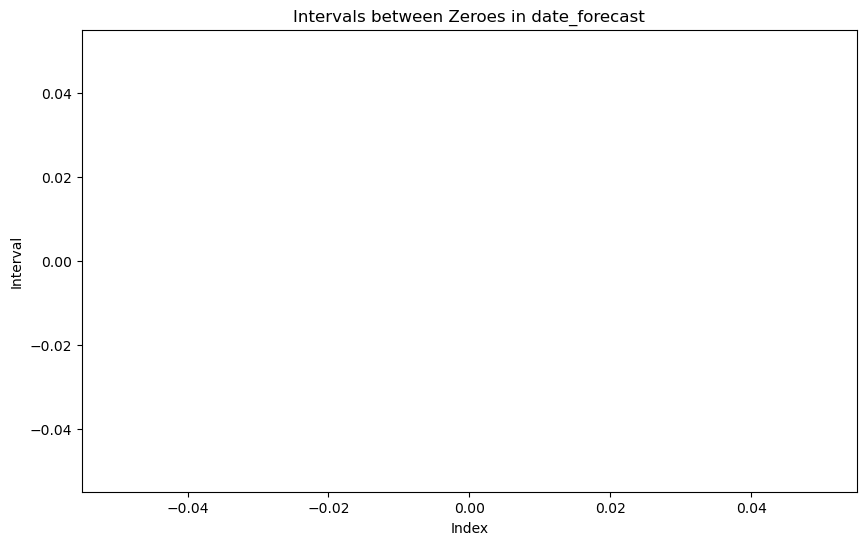

Feature: absolute_humidity_2m:gm3, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


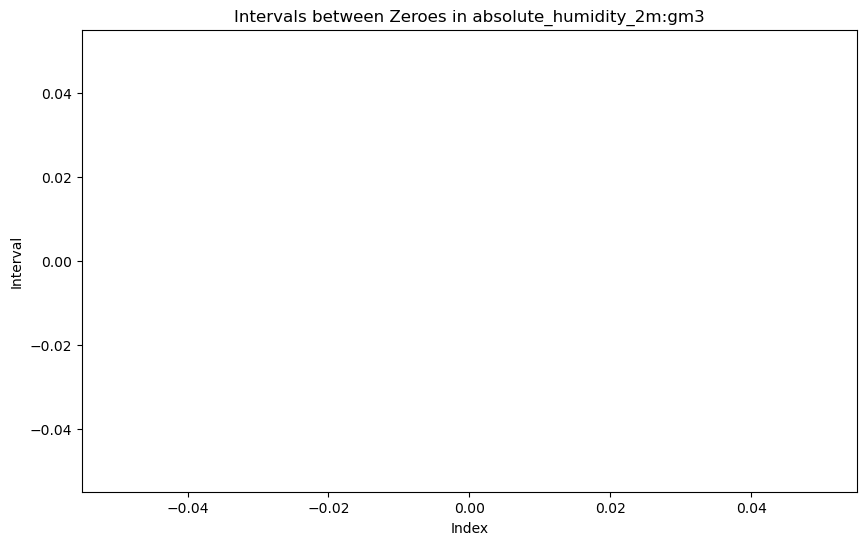

Feature: air_density_2m:kgm3, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


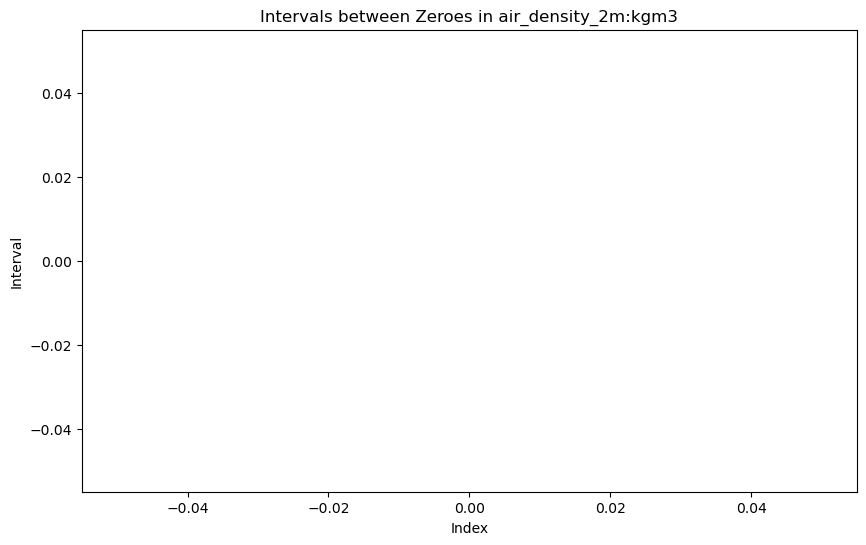

Feature: ceiling_height_agl:m, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


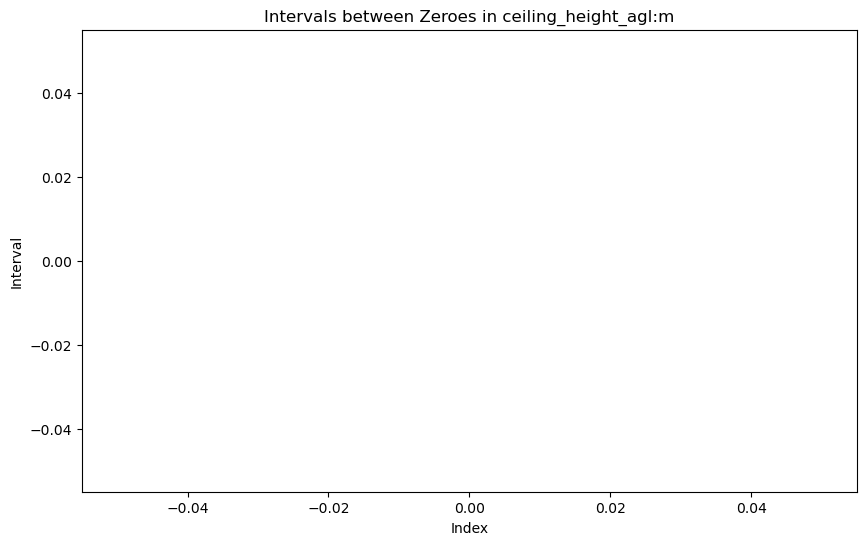

Feature: clear_sky_energy_1h:J, Number of zeroes: 11994
Intervals between zeroes:
       Interval
0             1
1             1
2            22
3             1
4             1
...         ...
11988         1
11989         1
11990         1
11991         1
11992         1

[11993 rows x 1 columns]


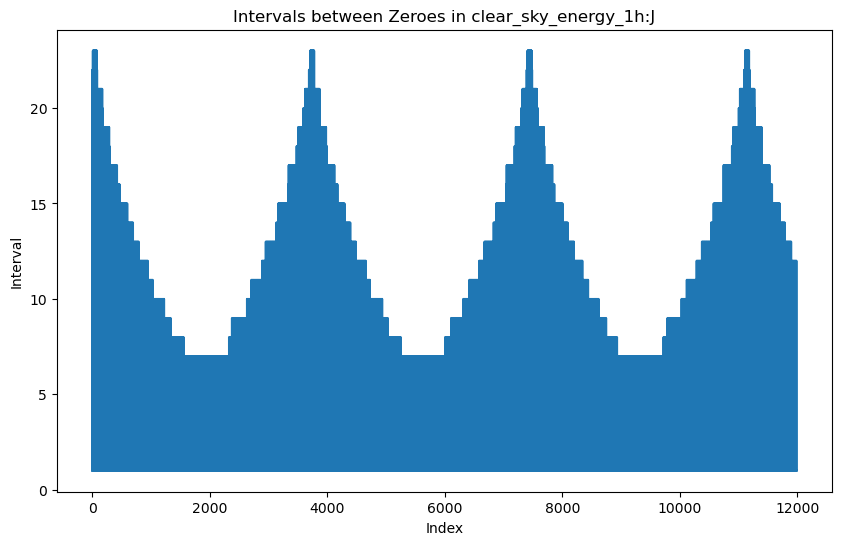

Feature: clear_sky_rad:W, Number of zeroes: 13236
Intervals between zeroes:
       Interval
0             1
1             1
2            21
3             1
4             1
...         ...
13230         1
13231         1
13232         1
13233         1
13234         1

[13235 rows x 1 columns]


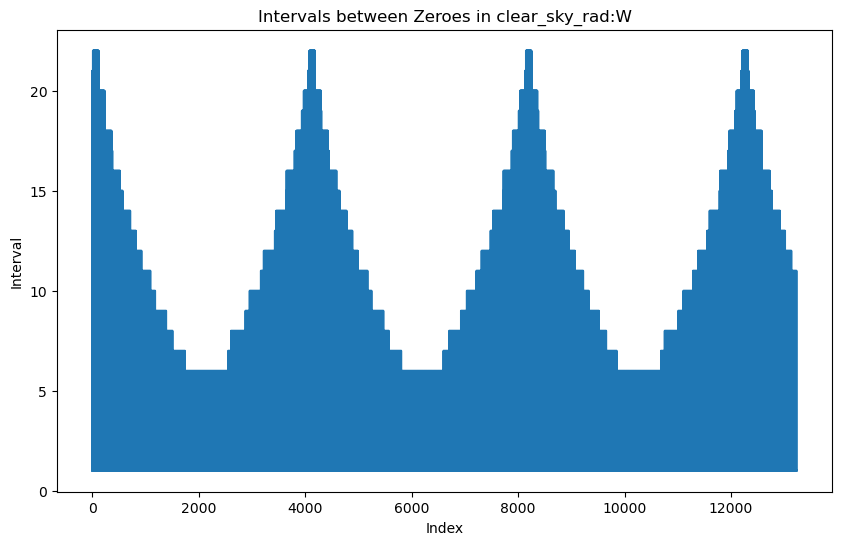

Feature: cloud_base_agl:m, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


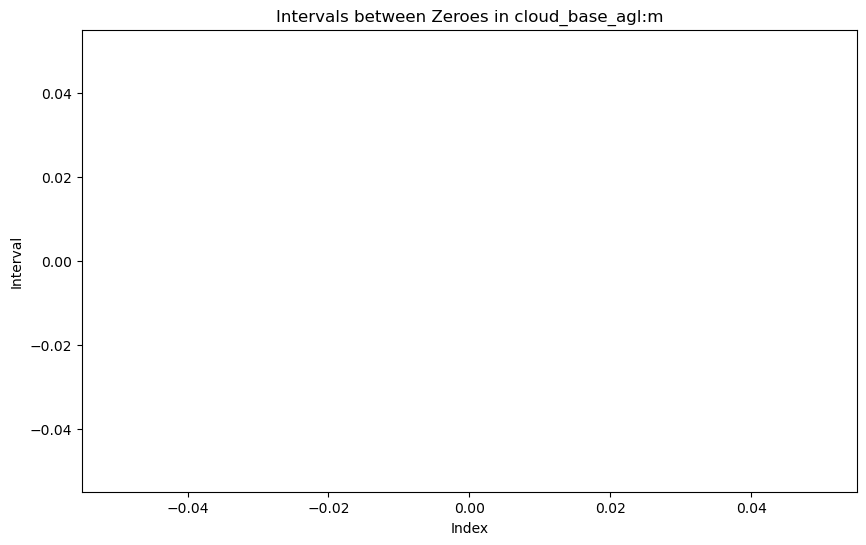

Feature: dew_or_rime:idx, Number of zeroes: 28376
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
28370         1
28371         1
28372         1
28373         1
28374         1

[28375 rows x 1 columns]


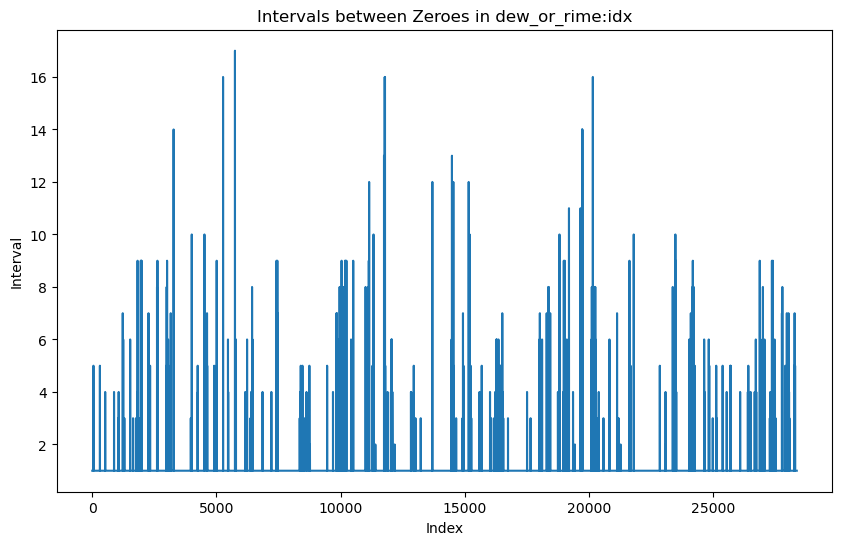

Feature: dew_point_2m:K, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


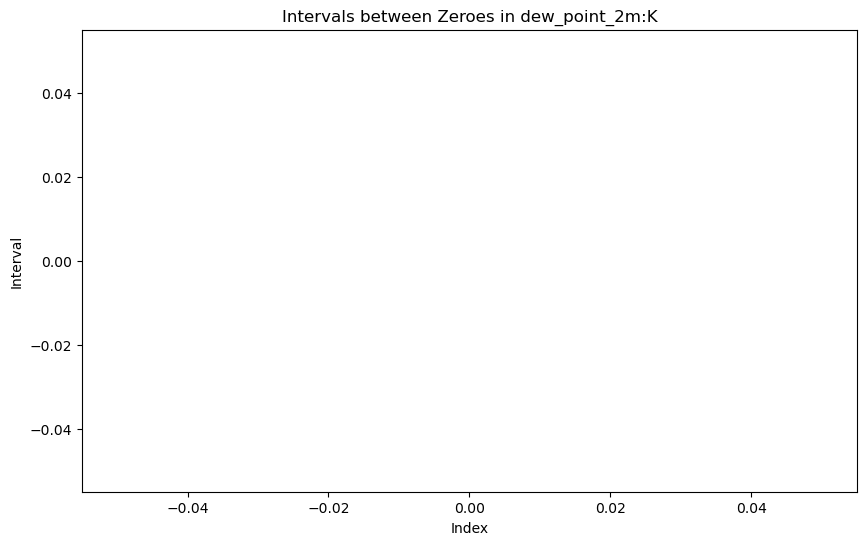

Feature: diffuse_rad:W, Number of zeroes: 13243
Intervals between zeroes:
       Interval
0             1
1             1
2            21
3             1
4             1
...         ...
13237         1
13238         1
13239         1
13240         1
13241         1

[13242 rows x 1 columns]


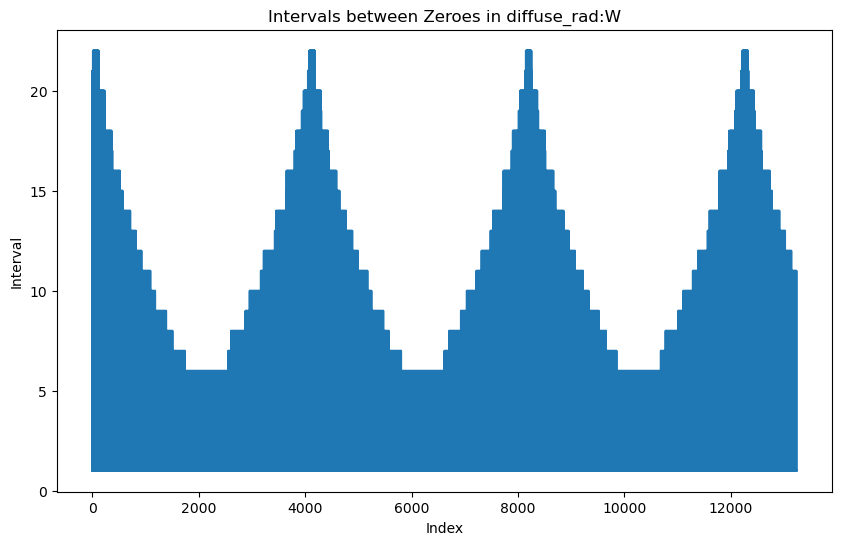

Feature: diffuse_rad_1h:J, Number of zeroes: 11997
Intervals between zeroes:
       Interval
0             1
1             1
2            22
3             1
4             1
...         ...
11991         1
11992         1
11993         1
11994         1
11995         1

[11996 rows x 1 columns]


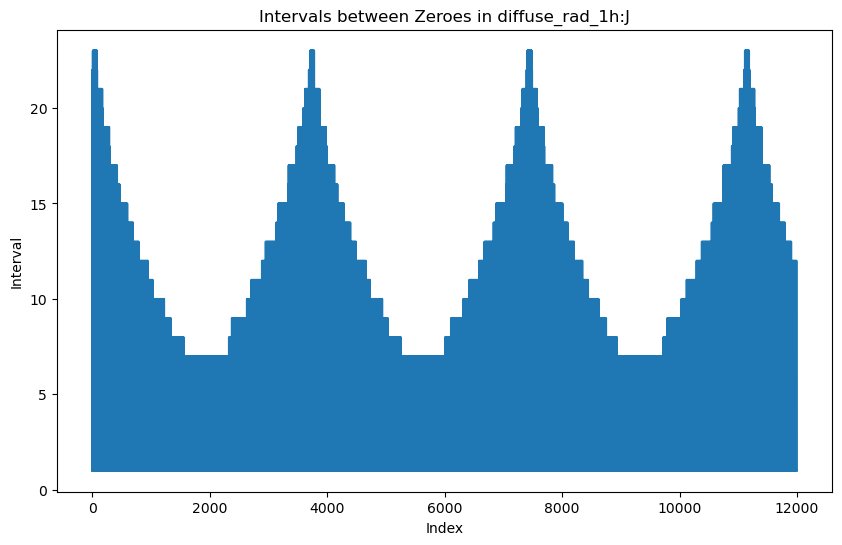

Feature: direct_rad:W, Number of zeroes: 15129
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3            20
4             1
...         ...
15123         1
15124         1
15125         1
15126         1
15127         1

[15128 rows x 1 columns]


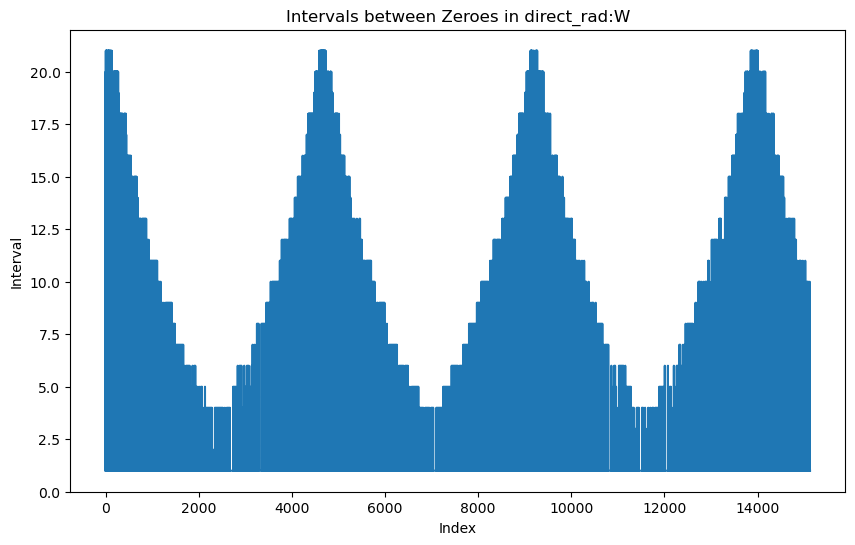

Feature: direct_rad_1h:J, Number of zeroes: 13554
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3            21
4             1
...         ...
13548         1
13549         1
13550         1
13551         1
13552         1

[13553 rows x 1 columns]


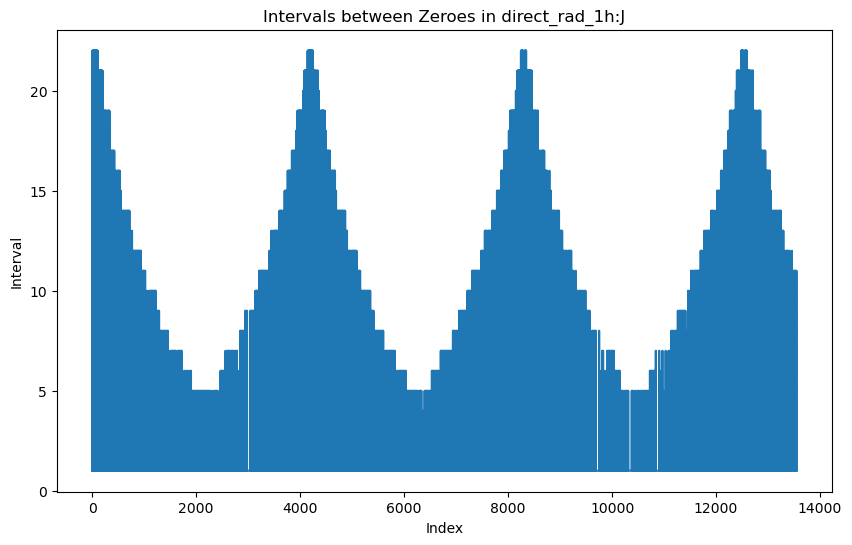

Feature: effective_cloud_cover:p, Number of zeroes: 865
Intervals between zeroes:
     Interval
0           1
1         849
2           1
3         308
4           1
..        ...
859        91
860       464
861         1
862         1
863        39

[864 rows x 1 columns]


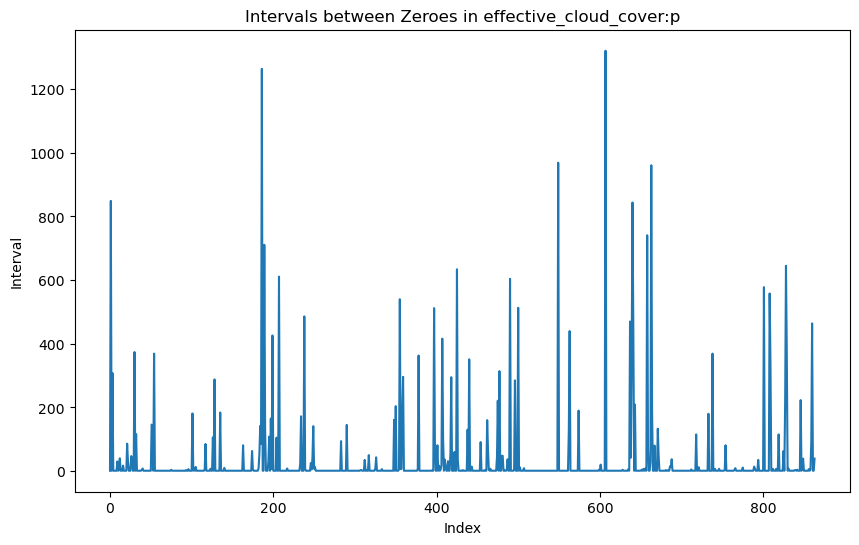

Feature: fresh_snow_12h:cm, Number of zeroes: 28759
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
28753         1
28754         1
28755         1
28756         1
28757         1

[28758 rows x 1 columns]


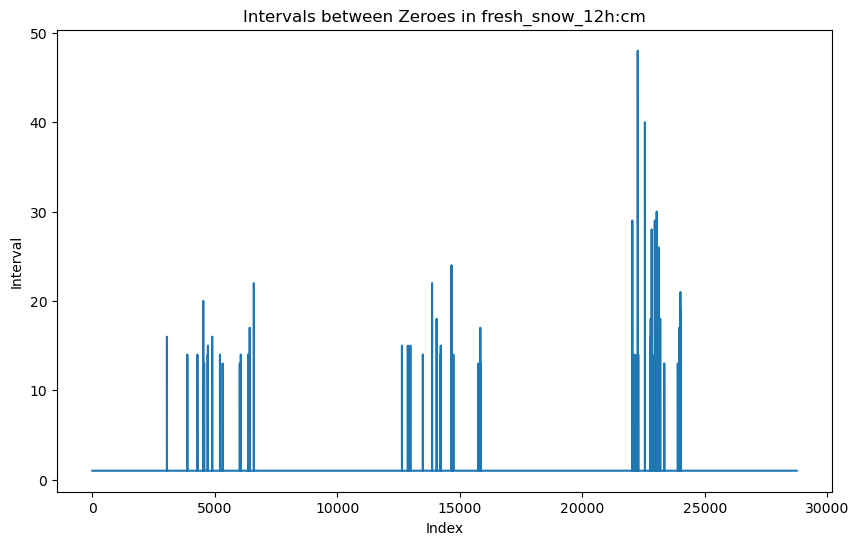

Feature: fresh_snow_1h:cm, Number of zeroes: 29416
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
29410         1
29411         1
29412         1
29413         1
29414         1

[29415 rows x 1 columns]


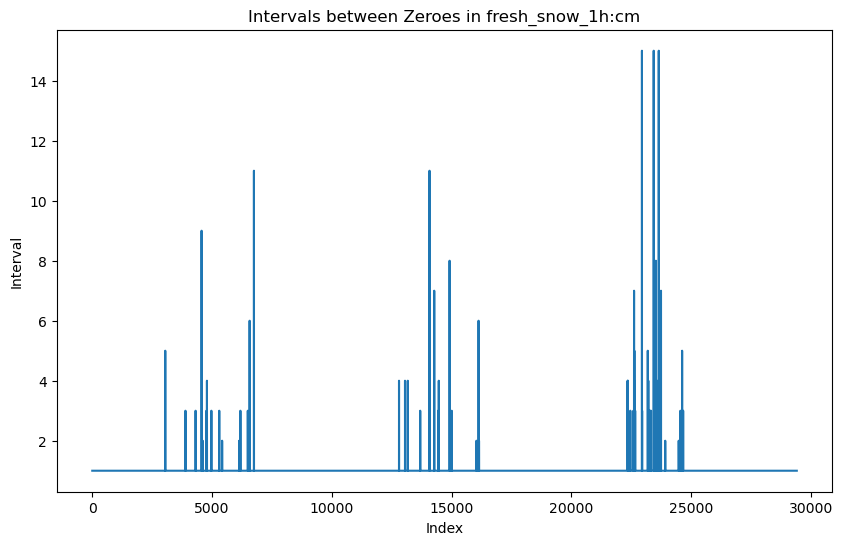

Feature: fresh_snow_24h:cm, Number of zeroes: 28144
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
28138         1
28139         1
28140         1
28141         1
28142         1

[28143 rows x 1 columns]


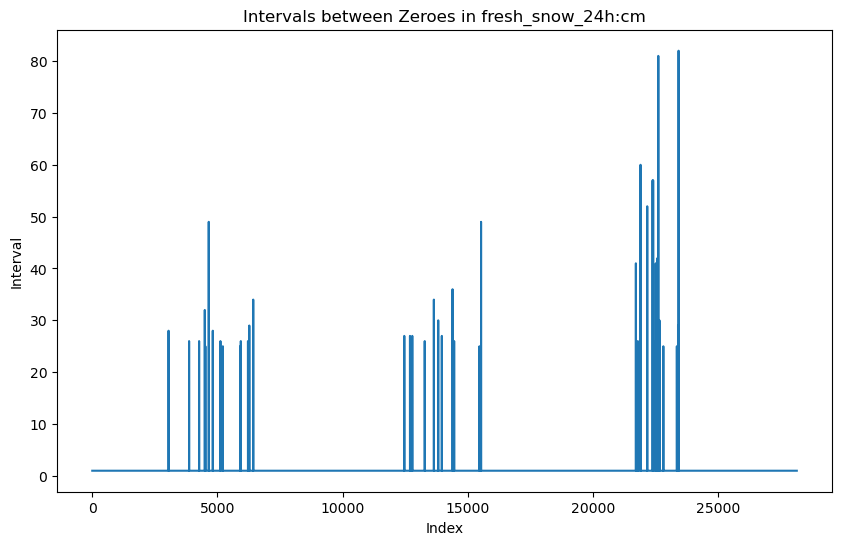

Feature: fresh_snow_3h:cm, Number of zeroes: 29271
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
29265         1
29266         1
29267         1
29268         1
29269         1

[29270 rows x 1 columns]


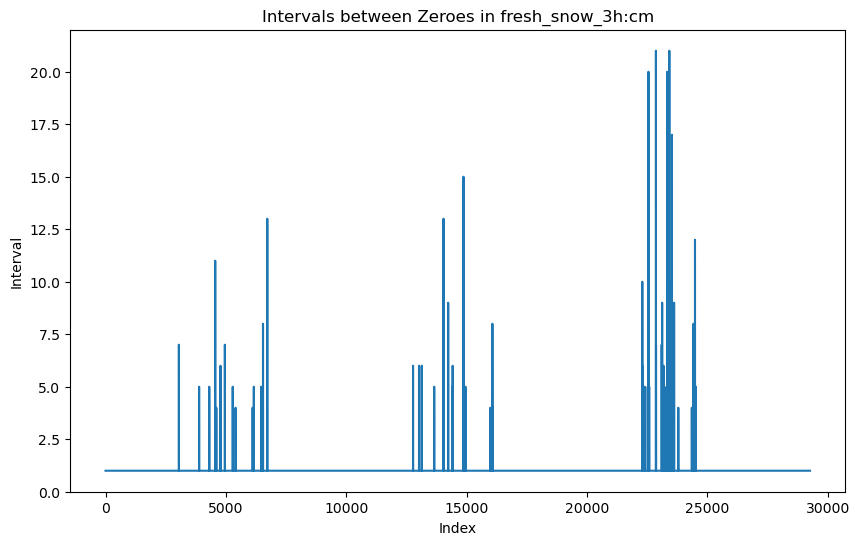

Feature: fresh_snow_6h:cm, Number of zeroes: 29096
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
29090         1
29091         1
29092         1
29093         1
29094         1

[29095 rows x 1 columns]


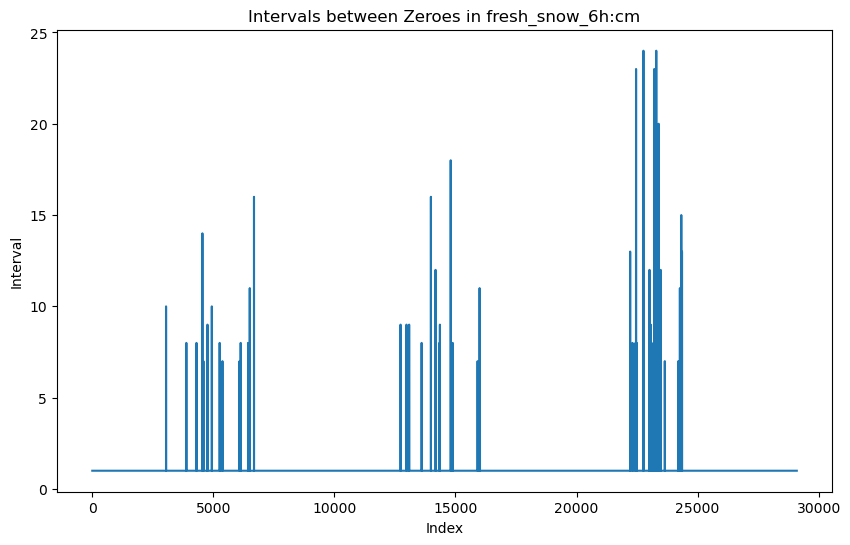

Feature: is_day:idx, Number of zeroes: 13230
Intervals between zeroes:
       Interval
0             1
1             1
2            21
3             1
4             1
...         ...
13224         1
13225         1
13226         1
13227         1
13228         1

[13229 rows x 1 columns]


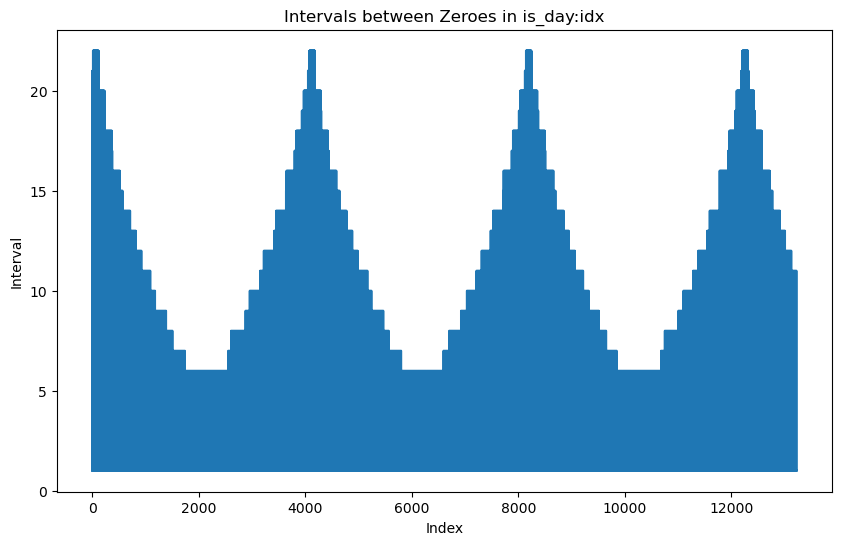

Feature: is_in_shadow:idx, Number of zeroes: 13613
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
13607         1
13608         1
13609         1
13610         1
13611         1

[13612 rows x 1 columns]


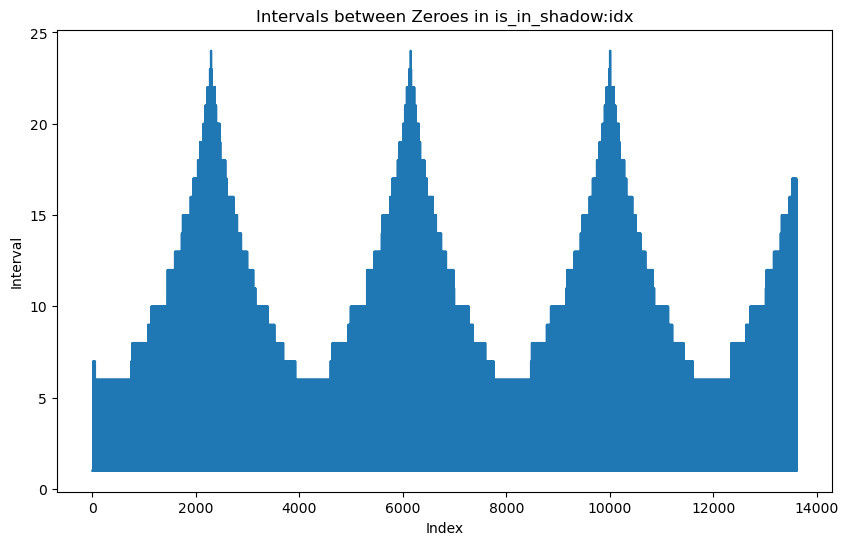

Feature: msl_pressure:hPa, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


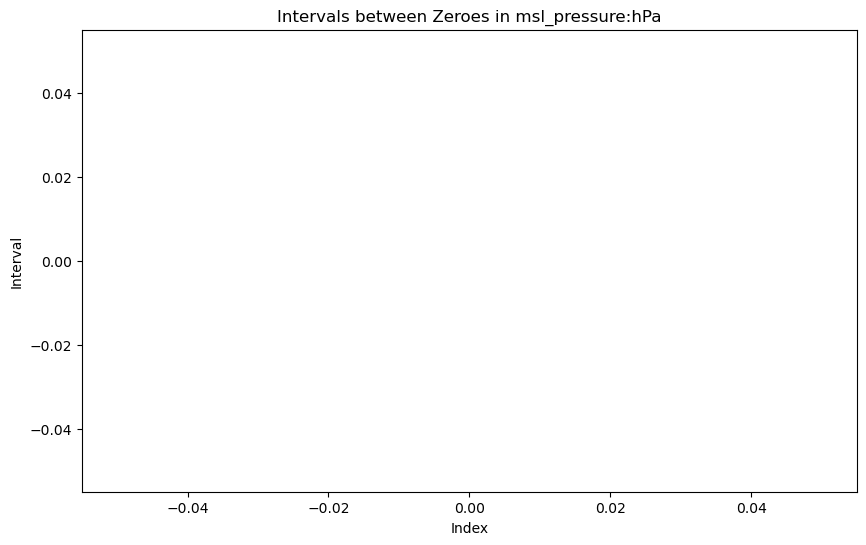

Feature: precip_5min:mm, Number of zeroes: 26212
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
26206         1
26207         1
26208         1
26209         1
26210         1

[26211 rows x 1 columns]


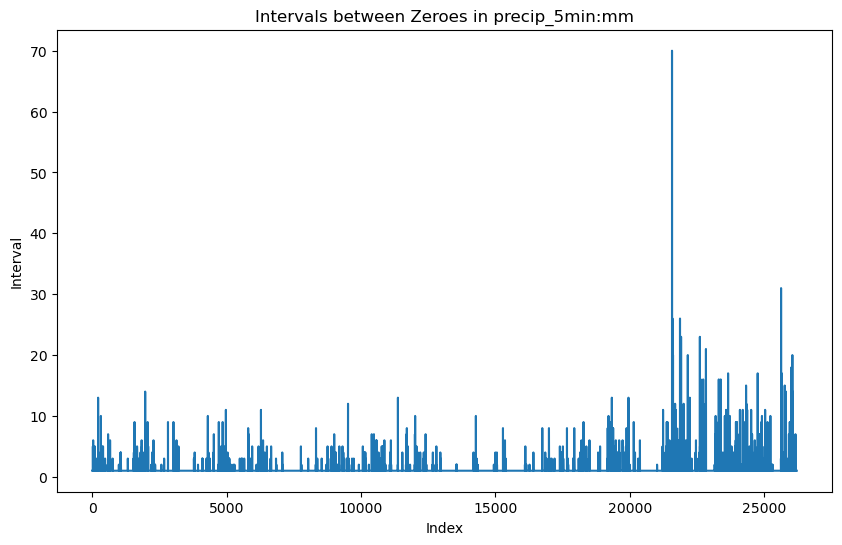

Feature: precip_type_5min:idx, Number of zeroes: 26212
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
26206         1
26207         1
26208         1
26209         1
26210         1

[26211 rows x 1 columns]


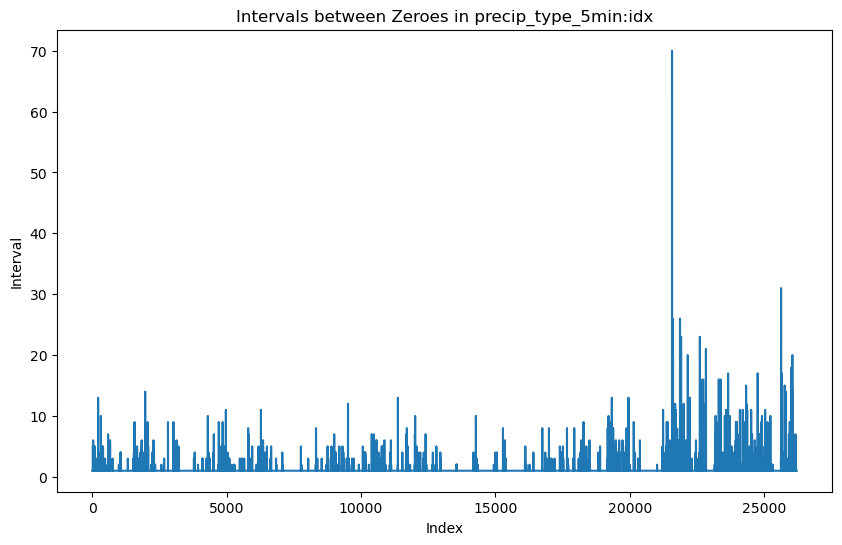

Feature: pressure_100m:hPa, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


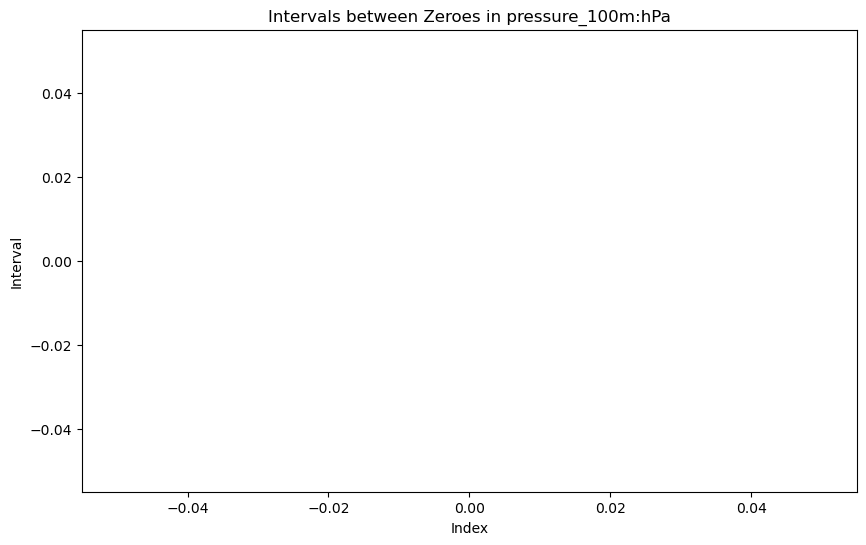

Feature: pressure_50m:hPa, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


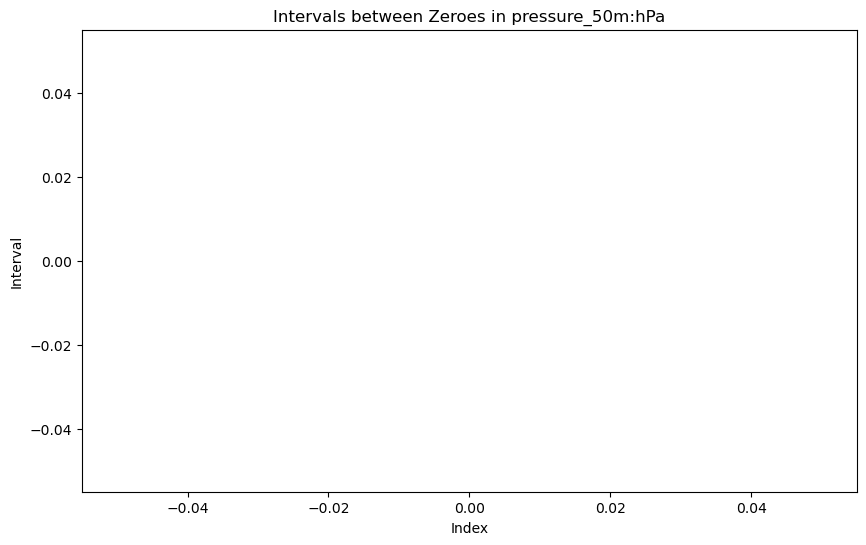

Feature: prob_rime:p, Number of zeroes: 29228
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
29222         1
29223         1
29224         1
29225         1
29226         1

[29227 rows x 1 columns]


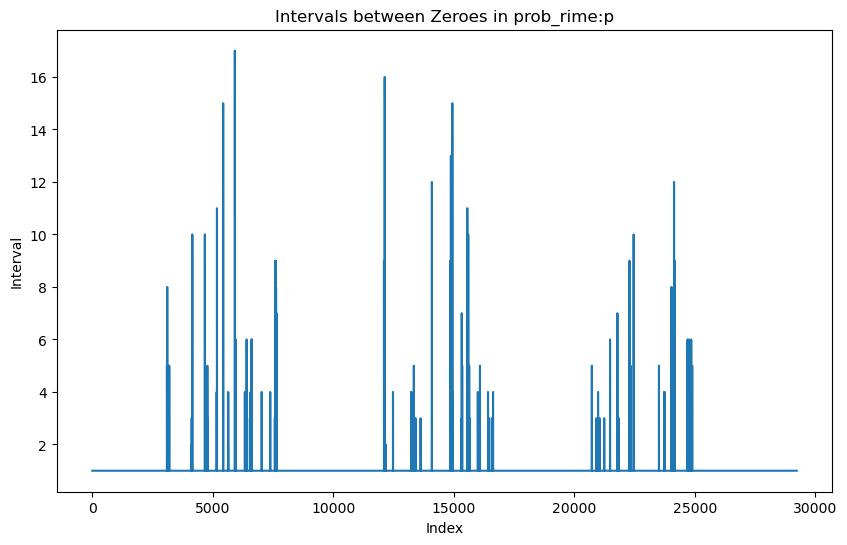

Feature: rain_water:kgm2, Number of zeroes: 26706
Intervals between zeroes:
       Interval
0             5
1             1
2             1
3             6
4             1
...         ...
26700         1
26701         1
26702         1
26703         1
26704         1

[26705 rows x 1 columns]


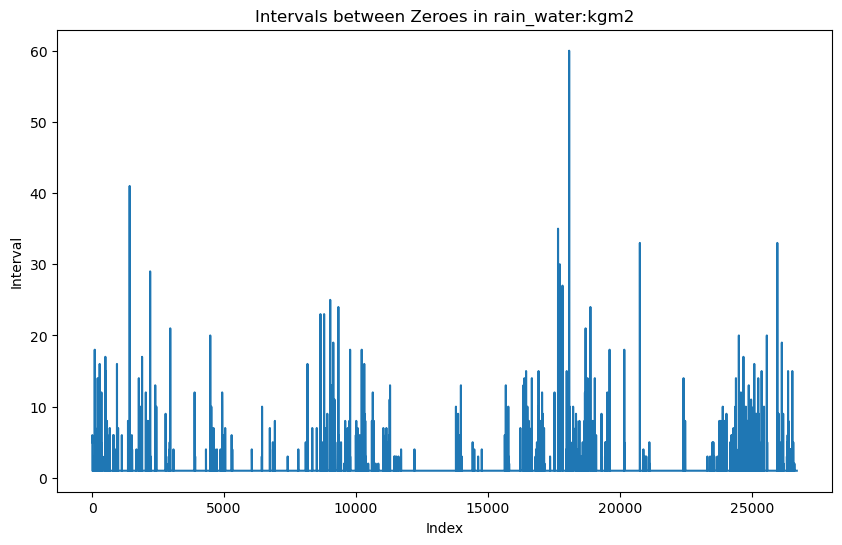

Feature: relative_humidity_1000hPa:p, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


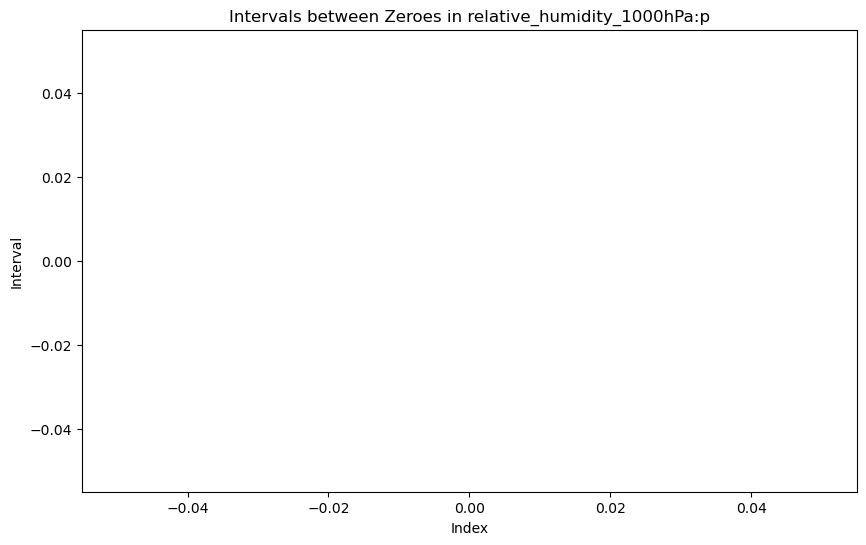

Feature: sfc_pressure:hPa, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


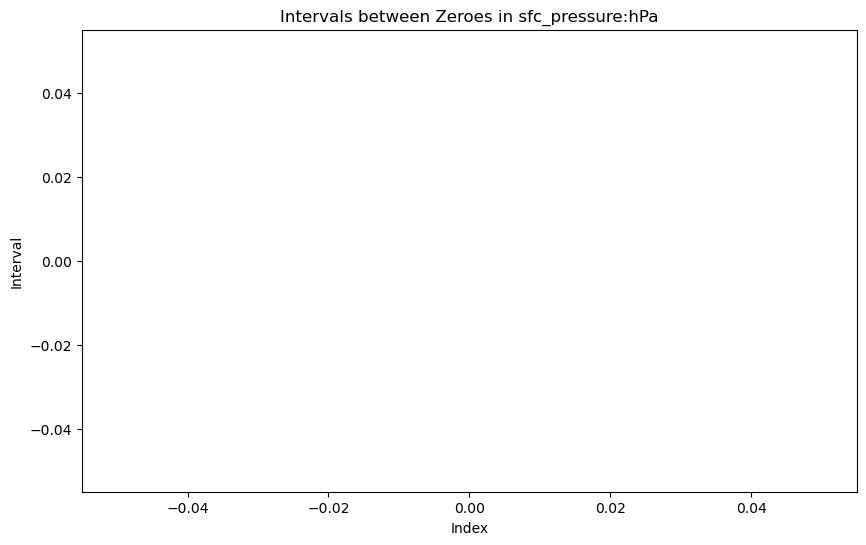

Feature: snow_depth:cm, Number of zeroes: 28979
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
28973         1
28974         1
28975         1
28976         1
28977         1

[28978 rows x 1 columns]


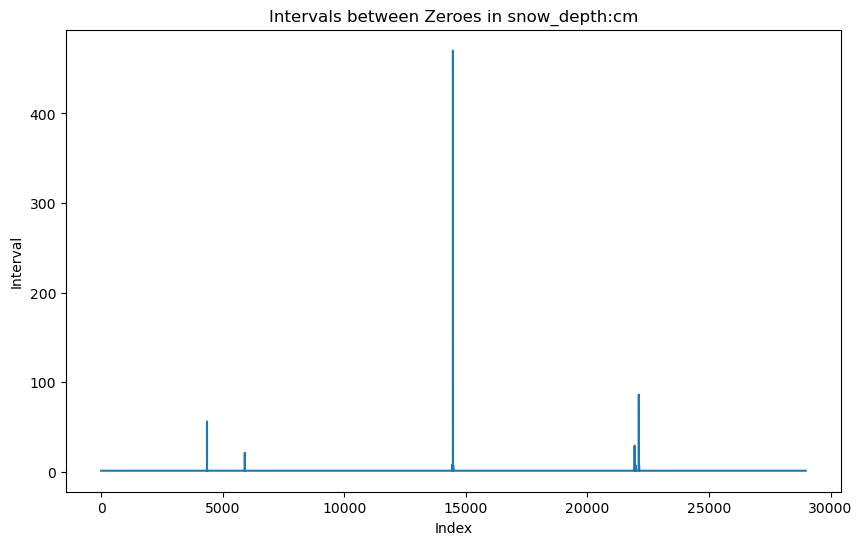

Feature: snow_melt_10min:mm, Number of zeroes: 29615
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
29609         1
29610         1
29611         1
29612         1
29613         1

[29614 rows x 1 columns]


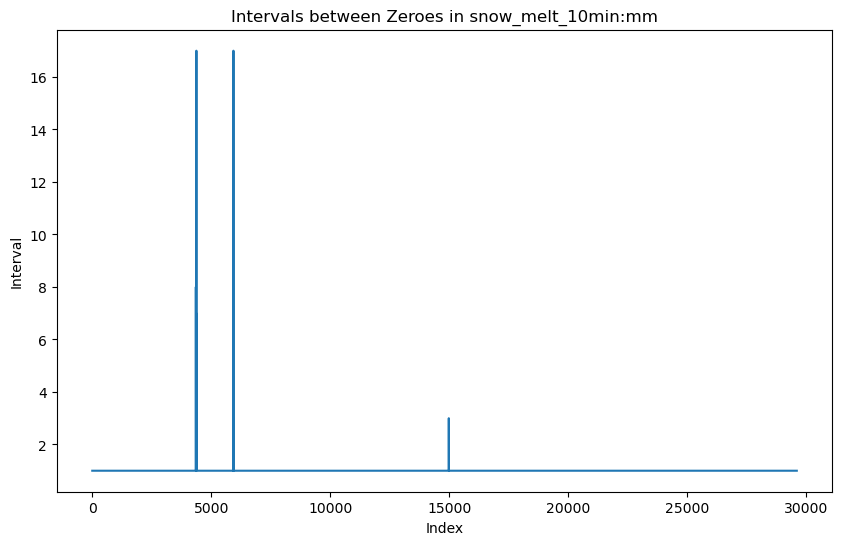

Feature: snow_water:kgm2, Number of zeroes: 19588
Intervals between zeroes:
       Interval
0             1
1             5
2             1
3             1
4             1
...         ...
19582         1
19583         1
19584         1
19585         1
19586         1

[19587 rows x 1 columns]


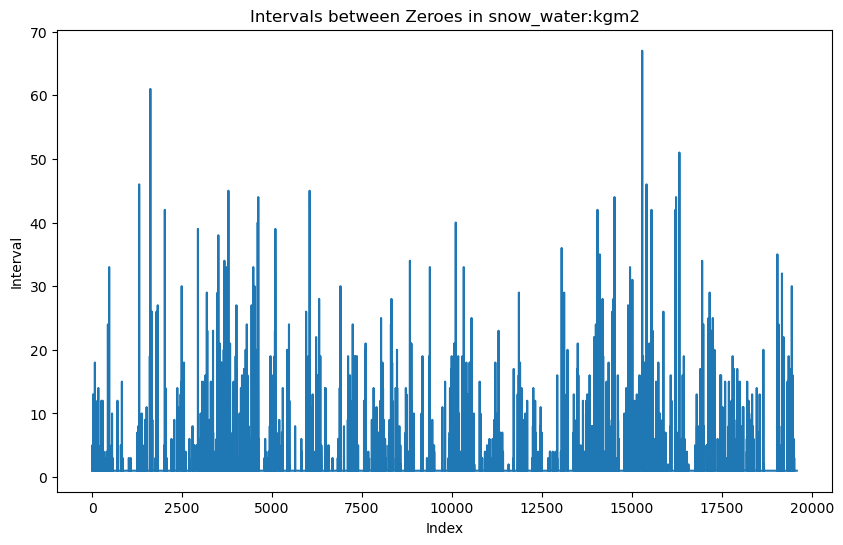

Feature: sun_azimuth:d, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


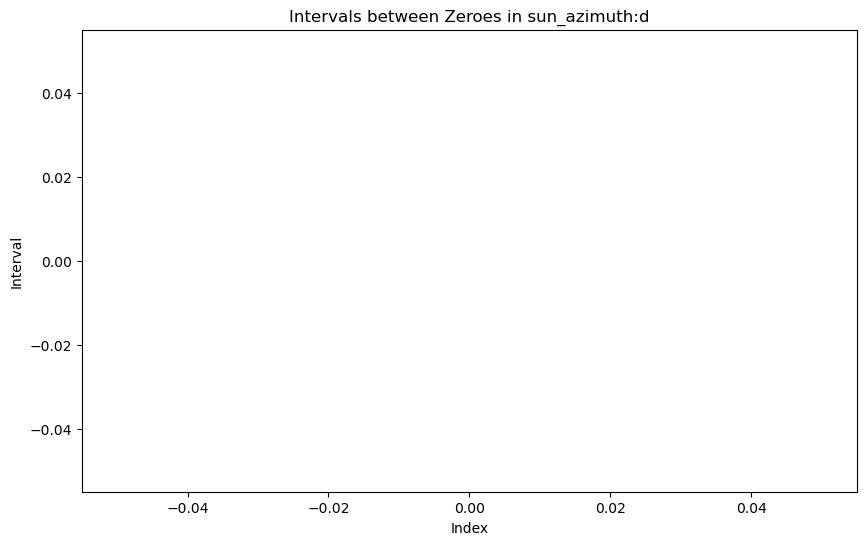

Feature: sun_elevation:d, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


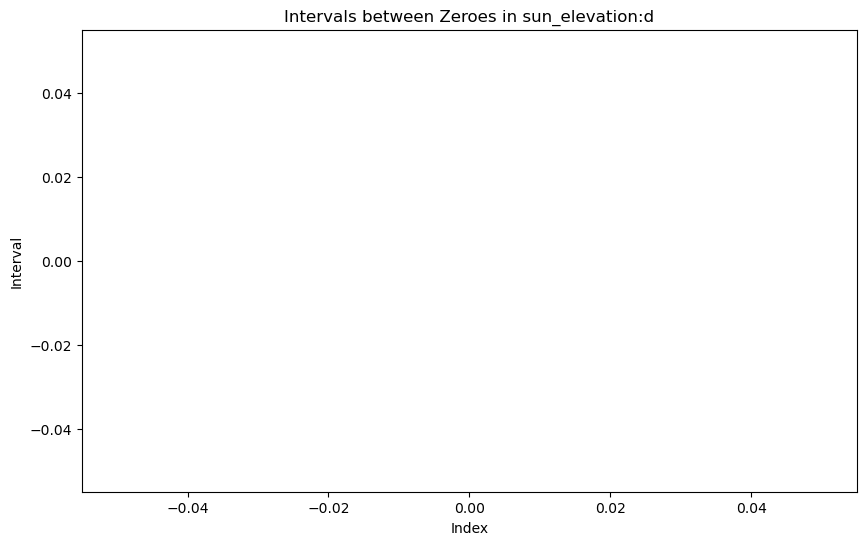

Feature: super_cooled_liquid_water:kgm2, Number of zeroes: 18635
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
18629         1
18630         1
18631         1
18632         1
18633         1

[18634 rows x 1 columns]


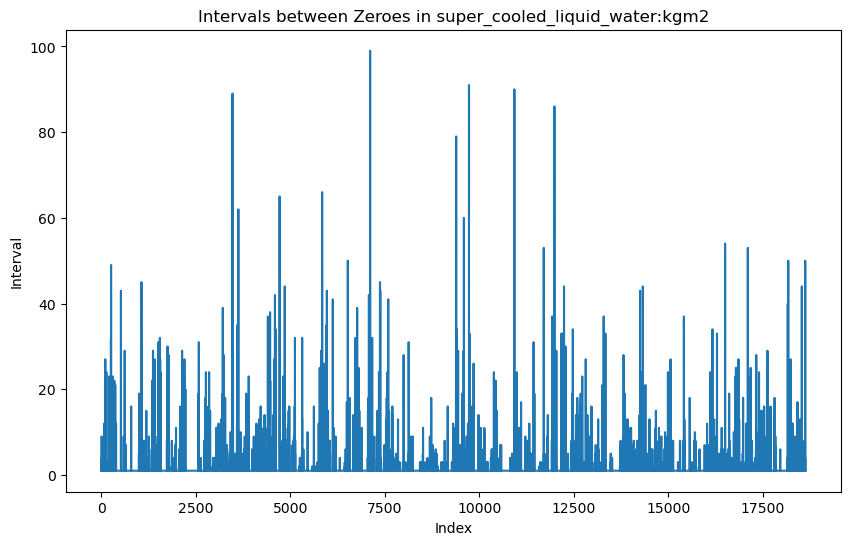

Feature: t_1000hPa:K, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


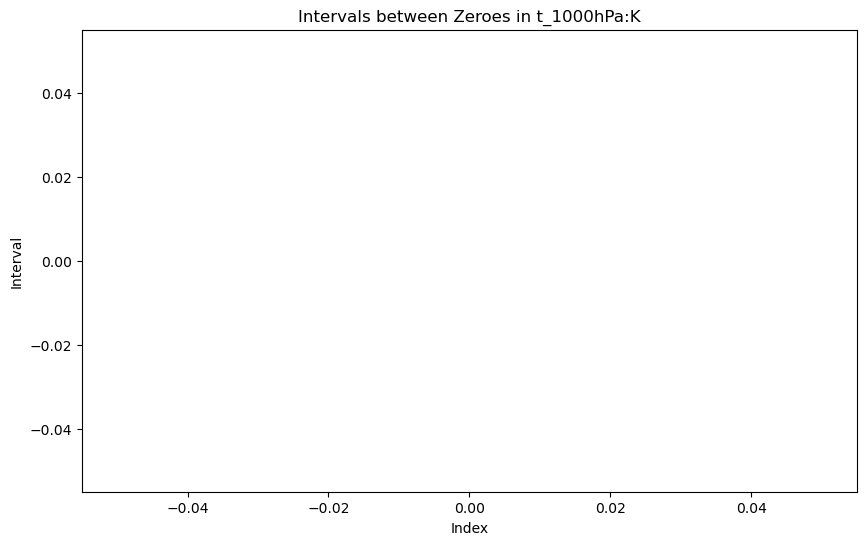

Feature: total_cloud_cover:p, Number of zeroes: 865
Intervals between zeroes:
     Interval
0           1
1         849
2           1
3         308
4           1
..        ...
859        91
860       464
861         1
862         1
863        39

[864 rows x 1 columns]


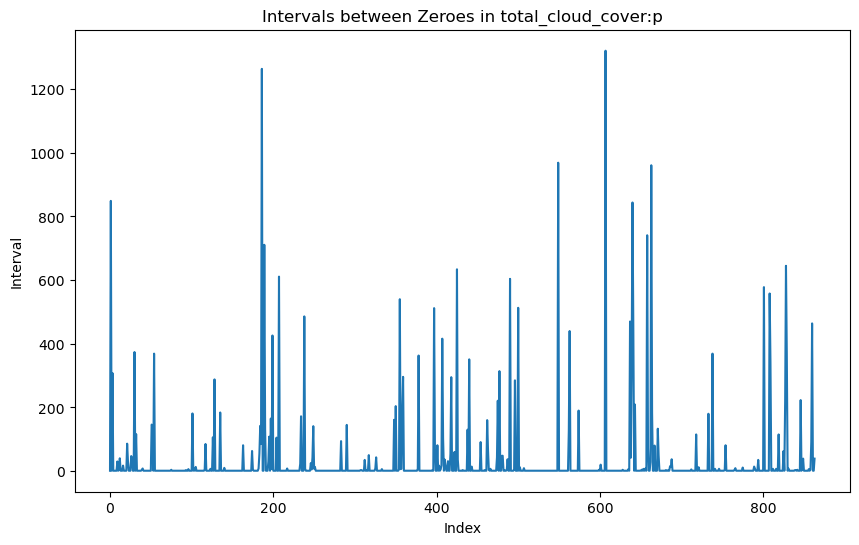

Feature: visibility:m, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


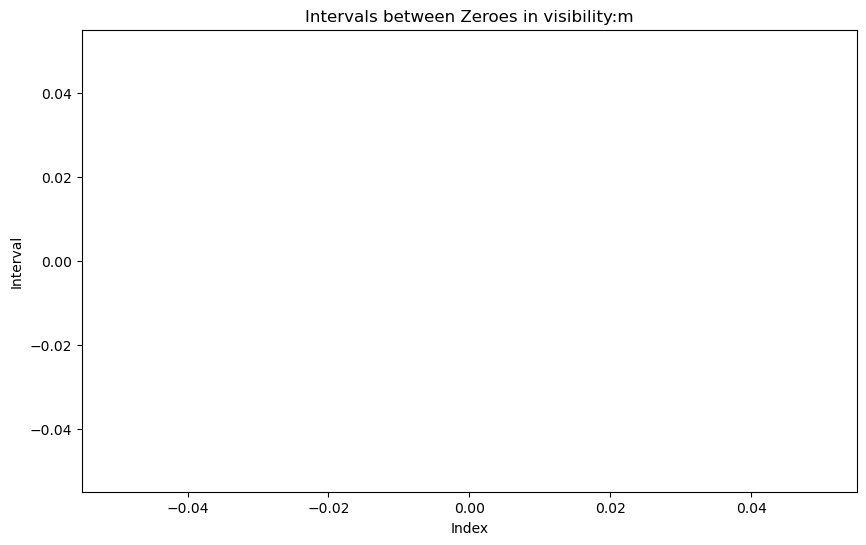

Feature: wind_speed_10m:ms, Number of zeroes: 0
Intervals between zeroes:
Empty DataFrame
Columns: [Interval]
Index: []


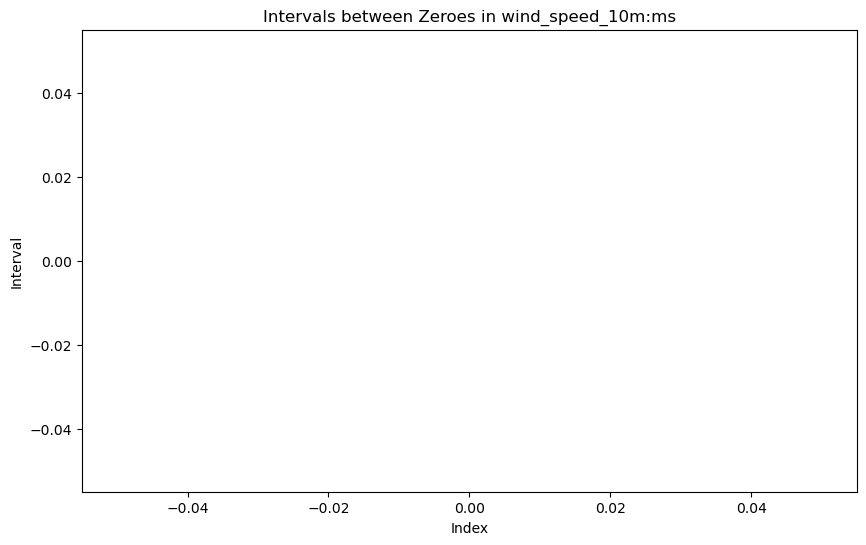

Feature: wind_speed_u_10m:ms, Number of zeroes: 131
Intervals between zeroes:
     Interval
0         836
1          41
2         133
3         775
4          36
..        ...
125       525
126       663
127       543
128        38
129       232

[130 rows x 1 columns]


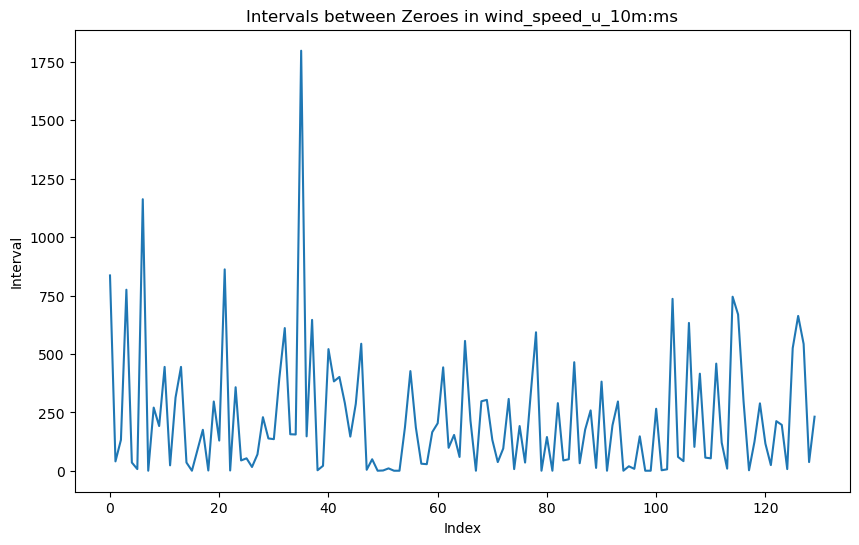

Feature: wind_speed_v_10m:ms, Number of zeroes: 193
Intervals between zeroes:
     Interval
0          75
1         456
2          98
3           1
4         309
..        ...
187       144
188       266
189        30
190       214
191       395

[192 rows x 1 columns]


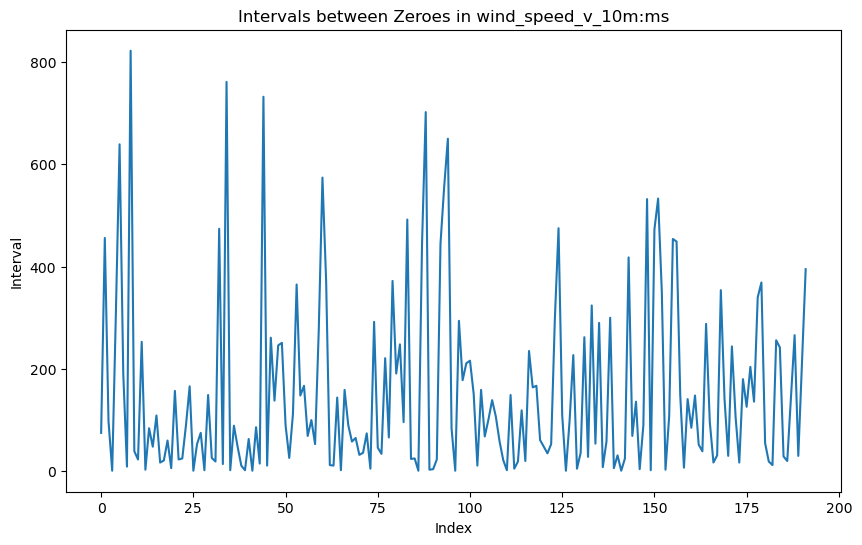

Feature: wind_speed_w_1000hPa:ms, Number of zeroes: 29657
Intervals between zeroes:
       Interval
0             1
1             1
2             1
3             1
4             1
...         ...
29651         1
29652         1
29653         1
29654         1
29655         1

[29656 rows x 1 columns]


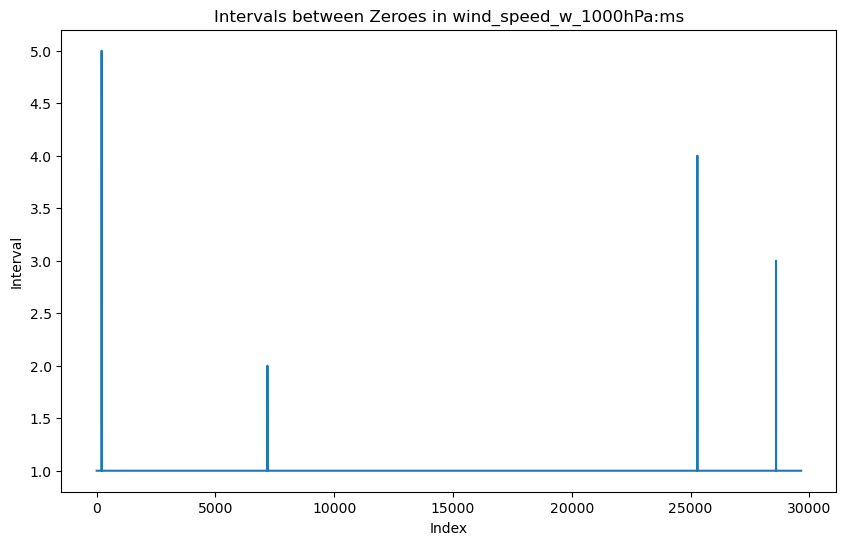

In [23]:

# List of feature columns
feature_columns = filtered_real_data.columns.tolist()
feature_columns.remove('pv_measurement')  # Remove the target column

# Loop through each feature and plot intervals between zeroes
for feature in feature_columns:
    # Count the number of zeroes
    zero_count = (filtered_real_data[feature] == 0).sum()
    print(f"Feature: {feature}, Number of zeroes: {zero_count}")

    # Find the indices where zeroes appear
    zero_indices = filtered_real_data.index[filtered_real_data[feature] == 0].tolist()

    # Calculate intervals between zero occurrences
    zero_intervals = [zero_indices[i+1] - zero_indices[i] for i in range(len(zero_indices)-1)]

    # Convert to DataFrame for better visualization
    zero_intervals_df = pd.DataFrame({'Interval': zero_intervals})

    print("Intervals between zeroes:")
    print(zero_intervals_df)

    # Plot the intervals
    plt.figure(figsize=(10, 6))
    plt.plot(zero_intervals_df['Interval'])
    plt.title(f"Intervals between Zeroes in {feature}")
    plt.xlabel("Index")
    plt.ylabel("Interval")
    plt.show()
